In [907]:
from __future__ import print_function, division

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=2.25)
import patsy
import scipy.stats as stats
from datetime import datetime as dt
import re
from bs4 import BeautifulSoup
import requests
import pickle
import random
import time

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score

%matplotlib inline

In [105]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# IMDb

### Scrape Titles and URLs from the search results

In [119]:
def get_movie_value(soup, field_name):
    '''
    Input a field_name and the function returns the next value in the HTML
    It only works for some values, so using it for Opening Weekend USA
    '''
    obj = soup.find(text=re.compile(field_name))

    if not obj: 
        return None

    next_element = obj.findNext()

    if next_element:
        return next_element.text 
    else:
        return None

In [121]:
# Initialize a list for the URLs against the filtered search results
# Total results: 1,734; sorted into pages with length 250

def get_imdb_urls(length_of_results):
    url = 'https://www.imdb.com/search/title/?title_type=feature&release_date=2010-01-01,2019-12-31&num_votes=25000,&count=250&start={}&ref_=adv_nxt'
    pages_urls = []
    for result in length_of_results:
        pages_urls.append(url.format(result)) # fills in placeholder above {} with result
    return pages_urls

length_of_results = list(range(1,1750,250)) # going through results 250s movies at a time
imdb_urls = get_imdb_urls(length_of_results)

In [123]:
titles = []
years = []
movie_urls = []
directors = []

# read in pages with BeautifulSoup
for page_url in imdb_urls:
    print(page_url)
#     page_url = pages_urls[0] # testing with first page of list to start reading in titles and URLs of actual movie pages
    response = requests.get(page_url)
    page = response.text
    soup = BeautifulSoup(page, 'lxml')

    # store all containers with the movie URL and title
    movie_divs = soup.find_all('div', class_='lister-item-content')

    # iterate through the headers to extract title, year, URL, and director   

    for div in movie_divs:
        movie = []
        # title
        titles.append(div.find('h3', class_ = 'lister-item-header').a.text)

        # year
        (years.append(int((div.find('span', class_ = 'lister-item-year text-muted unbold').text)
                          .replace('(','').replace(')','').replace('I','').replace('X','').replace('V','').strip())))

        # director
        d1 = div.find_next('p', class_='').text.split('|')
        d2 = d1[0].replace('Director:','').replace('Directors:','').strip().split(',')
        director = d2[0].strip()
        directors.append(director)
        
        # url
        for href in div.find_all(href=re.compile("^/title/........./$")):
            movie_urls.append('https://imdb.com' + href.get('href'))

https://www.imdb.com/search/title/?title_type=feature&release_date=2010-01-01,2019-12-31&num_votes=25000,&count=250&start=1&ref_=adv_nxt
https://www.imdb.com/search/title/?title_type=feature&release_date=2010-01-01,2019-12-31&num_votes=25000,&count=250&start=251&ref_=adv_nxt
https://www.imdb.com/search/title/?title_type=feature&release_date=2010-01-01,2019-12-31&num_votes=25000,&count=250&start=501&ref_=adv_nxt
https://www.imdb.com/search/title/?title_type=feature&release_date=2010-01-01,2019-12-31&num_votes=25000,&count=250&start=751&ref_=adv_nxt
https://www.imdb.com/search/title/?title_type=feature&release_date=2010-01-01,2019-12-31&num_votes=25000,&count=250&start=1001&ref_=adv_nxt
https://www.imdb.com/search/title/?title_type=feature&release_date=2010-01-01,2019-12-31&num_votes=25000,&count=250&start=1251&ref_=adv_nxt
https://www.imdb.com/search/title/?title_type=feature&release_date=2010-01-01,2019-12-31&num_votes=25000,&count=250&start=1501&ref_=adv_nxt


In [124]:
titles_years_urls_directors = list(zip(titles,years,movie_urls,directors))
movies_df = pd.DataFrame(titles_years_urls_directors, columns = ['TITLE','YEAR','URL','DIRECTOR'])

In [126]:
movies_df.to_pickle('movies_list_pickle.pkl')


In [127]:
with open("movies_list_pickle.pkl", 'rb') as picklefile: 
    movies_df = pickle.load(picklefile)
    

### Begin reading through movies URLs and scraping individual pages for dimensions

* Title
* Year
* MPAA Rating
* Runtime
* Genre
* Release Date
* IMDB Rating
* \# of IMDB User ratings
* Metascore
* \# of User Reviews
* \# of Critic Reviews
* Also Known As
* Budget
* Opening Weekend Gross USA
* Gross USA
* Cumulative Worldwide Gross
* Production Co
* Opening Weekend USA

In [ ]:
cols = [
    'TITLE', 'YEAR', 'MPAA_RATING', 'RUNTIME', 'GENRE', 'IMDB_RATING',
    'NUM_IMDB_RATINGS', 'METASCORE', 'COUNT_USER_REVIEWS', 'COUNT_CRITIC_REVIEWS',
    'AKA', 'BUDGET', 'OPENING_WKND_GROSS_USA', 'GROSS_USA', 'CUM_WRLD_GROSS',
    'PRODUCTION_COS', 'RELEASE_DATE'
]

In [ ]:
all_movie_dims = []


In [ ]:
'''
Use this code to isolate specific movies that aren't able to be scraped within the larger for loop below
'''

# movies_dict = {}
# loc = len(all_movie_dims) + 2
# loc = 66
# movies_dict[movies_df['TITLE'].iloc[loc]] = movies_df['URL'].iloc[loc] # testing with first page of list to scrape in other dimensions
# movies_dict

In [ ]:
movies_dict = {}
for row in range(loc,len(movies_df)):
# for row in range(50):
    movies_dict[movies_df['TITLE'].iloc[row]] = movies_df['URL'].iloc[row]


In [ ]:
# looping through the movies in the dictionary

for value in movies_dict.values():
    response = requests.get(value)
    movie_page = response.text
    movie_soup = BeautifulSoup(movie_page, 'lxml')

    # build a list with all of the dimensions (including title)

    # Get the title, year
    title_year = movie_soup.find('div', class_ = 'title_wrapper').find('h1').text
    title_year = title_year.strip().split("\xa0")
    movie_dims = [i for i in title_year]
    movie_dims[1] = int(movie_dims[1].replace('(','').replace(')',''))
    
    # Subtext with mpaa rating, runtime, genre needs to be split and stripped
    movie_dims.append(movie_soup.find('div', class_ = 'title_wrapper').find('div', class_='subtext').text)
    mpaa_runtime_genre_date = movie_dims.pop(2)
    mpaa_runtime_genre_date = mpaa_runtime_genre_date.split('|')
    m_list = [i.strip().replace('\n','') for i in mpaa_runtime_genre_date]
    ratings = ['G', 'PG', 'PG-13', 'R', 'NC-17','TV-MA', 'TV-14', 'TV-PG', 'Not Rated']
    if m_list[0] not in ratings:
        m_list.insert(0,None)
    m_list.pop()
    for dimension in m_list:
        movie_dims.append(dimension)

    # IMDb Rating and number of ratings
    def imdb_rating(soup,itemprops):
        dimensions = []
        for itemprop in itemprops:
            movie_dims.append(float(soup.find('div', class_ = 'ratings_wrapper').find('span', itemprop=itemprop).text.replace(',','')))

    imdb_rating_itemprops = ['ratingValue','ratingCount']
    imdb_rating(movie_soup,imdb_rating_itemprops)

    # Metascore
    try:
        movie_dims.append(int(movie_soup.find("div", class_=re.compile("^metacriticScore score")).text.strip()))
    except:
        movie_dims.append(None)

    # Number of Metascore User and Critic Reviews, clean and transform str to int
    try:
        movie_dims.append(int(movie_soup.find(string=re.compile("(\d+(?:,d+)*) user")).replace('user','').replace(',','')))
    except:
        movie_dims.append(None)
        
    try:
        movie_dims.append(int(movie_soup.find(string=re.compile("(\d+(?:,d+)*) critic")).replace('critic','').replace(',','')))
    except:
        movie_dims.append(None)

    # Create dictionary with all h4 classes and values to append values in labels below
    h4_dict = {}
    for h4 in movie_soup.find_all('h4', class_='inline'):
        h4_dict[h4.text.replace(':','')] = h4.next_sibling.strip().replace('$','').replace(',','')

    labels = ['Also Known As', 'Budget', 'Opening Weekend USA', 'Gross USA', 'Cumulative Worldwide Gross']
    for label in labels:
        movie_dims.append(h4_dict.get(label))


    # Get the production companies into one list and append all production companies as a list into movie_dims
    pro_co = [i.text for i in movie_soup.findAll('a', attrs={'href': re.compile("^/company")})]
    movie_dims.append(pro_co)

    # get opening weekend in the USA, if streaming title need to use release date
    try:
        movie_dims.append(dt.strptime(get_movie_value(movie_soup,'Opening Weekend USA:'), '%d %B %Y'))
    except:
        movie_dims.append(h4_dict.get('Release Date'))
    
    # Append the movie's dimensions to the larger movie dims list
    # If the movie doesn't have all 17 dimensions, print the movie and break the loop
    if len(movie_dims) == 17:
        all_movie_dims.append(movie_dims)
    else:
        print(movie_dims)
        break
    
    time.sleep(.5+2*random.random()) # Randomize the pattern of scraping to prevent getting flagged

In [ ]:
def len_check():
    '''
    Check to make sure all movies have 17 dimensions included
    Will return the full list of movies that need to be re-run
    '''
    
    incorrect = []
    for i in all_movie_dims:
        if len(i) != 17:
            incorrect.append(i)
    return incorrect

len_check()


In [ ]:
imdb_df = pd.DataFrame(all_movie_dims, columns = cols)

In [ ]:
imdb_df.to_pickle('imdb_pickle.pkl')

In [715]:
with open("movie_dims_pickle.pkl", 'rb') as dims_picklefile: 
    imdb_df = pickle.load(dims_picklefile)

# The Numbers

### Create a list of URLs to read in

In [ ]:
def get_thenumbers_urls(length_of_results):
    """
    Initialize a list for the URLs against the filtered search results for the-numbers.com
    Total results: 5,923; sorted into pages with length 100
    """
    
    url = 'https://www.the-numbers.com/movie/budgets/all/{}'
    pages_urls = []
    for result in length_of_results:
        pages_urls.append(url.format(result)) # fills in placeholder above {} with result
    return pages_urls

length_of_thenumbers = list(range(1,5902,100)) # going through results 250s movies at a time
thenumbers_urls = get_thenumbers_urls(length_of_thenumbers)

In [ ]:
# Columns to be scraped from The Numbers
thenumbers_cols = ['TITLE', 'DATE', 'BUDGET_TN', 'GROSS_USA_TN', 'CUM_WRLD_GROSS_TN']

In [ ]:
# Setting up list for all movies to be appended to
thenumbers_movies = []

# read in pages with BeautifulSoup
for page_url in thenumbers_urls:
#     page_url = pages_urls[0] # testing with first page of list to start reading in titles and URLs of actual movie pages
    response = requests.get(page_url)
    page = response.text
    thenumbers_soup = BeautifulSoup(page, 'lxml')
    
    # read through all of the <tr> headers in the page, one header per movie
    tr_headers = thenumbers_soup.find_all('tr')
    
    # For each header in the page, obtain the variables necessary and append to thenumbers_movies list by movie
    for tr in thenumbers_soup.find_all('tr')[1:]:
        tds = tr.find_all('td')
        movie = [tds[2].text, # Title
                 int(tds[3].text.replace('$','').replace(',','')), # Budget
                 int(tds[4].text.replace('$','').replace(',','')), # Gross USA
                 int(tds[5].text.replace('$','').replace(',','')),] # Cumulative Worldwide Gross
        
        # some movies don't have a release date, so input None for those without
        try:
            movie[1:1] = [dt.strptime(tds[1].text, '%b %d, %Y')] # Date
        except:
            movie[1:1] = [None]
        thenumbers_movies.append(movie)

In [ ]:
thenumbers_df = pd.DataFrame(thenumbers_movies, columns = thenumbers_cols)
thenumbers_df

In [ ]:
# input a new column for release year to help with matching
thenumbers_df['YEAR'] = pd.DatetimeIndex(thenumbers_df['DATE']).year

In [ ]:
# input a new column for release month to help assess the impact of time of year
thenumbers_df['MONTH'] = pd.DatetimeIndex(thenumbers_df['DATE']).month

In [ ]:
thenumbers_df.to_pickle('thenumbers_pickle.pkl')

In [716]:
with open("thenumbers_pickle.pkl", 'rb') as thenumbers_picklefile: 
    thenumbers_df = pickle.load(thenumbers_picklefile)

# Data Cleansing and Joining

In [717]:
thenumbers_df.head()
len(thenumbers_df)

5923

In [718]:
imdb_df.head()
len(imdb_df)

1739

In [719]:
movies_df.head()
len(movies_df)

1743

In [720]:
runtimelist = imdb_df['RUNTIME'].tolist()

In [721]:
def runtime_to_minutes(runtimelist):
    '''
    Convert the existing ['RUNTIME'] column format of '\dh \dmin'
    to minutes for easier calculations
    '''
    runtime_minutes = []
    list_ = ['h', 'min']
    for runtime in runtimelist:
        if 'h' not in runtime:
            minutes = int(runtime.replace('min',''))
            runtime_minutes.append(minutes)
        elif 'min' not in runtime:
            minutes = int(runtime[0])*60
            runtime_minutes.append(minutes)
        else:
            runtime_list = runtime.replace('h','').replace('min','').split()
            minutes = int(runtime_list[0])*60 + int(runtime_list[1])
            runtime_minutes.append(minutes)
    return runtime_minutes

runtime_min = runtime_to_minutes(runtimelist)
len(runtime_min) == len(imdb_df)

True

In [722]:
imdb_df['RUNTIME_MIN'] = np.asarray(runtime_min)

In [723]:
movies_df.head()

,TITLE,YEAR,URL,DIRECTOR
0,1917,2019,https://imdb.com/title/tt8579674/,Sam Mendes
1,Joker,2019,https://imdb.com/title/tt7286456/,Todd Phillips
2,Parasite,2019,https://imdb.com/title/tt6751668/,Bong Joon Ho
3,Little Women,2019,https://imdb.com/title/tt3281548/,Greta Gerwig
4,Once Upon a Time... in Hollywood,2019,https://imdb.com/title/tt7131622/,Quentin Tarantino


In [724]:
# limit the-numbers df to only include movies released in the 2010s to limit overlap with remakes
thenumbers_clean = thenumbers_df[(thenumbers_df['DATE'] >= '2010-01-01')]
thenumbers_clean

,TITLE,DATE,BUDGET_TN,GROSS_USA_TN,CUM_WRLD_GROSS_TN,YEAR,MONTH
0,Avengers: Endgame,2019-04-23,400000000,858373000,2797800564,2019.000,4.000
1,Pirates of the Caribbean: On Stranger Tides,2011-05-20,379000000,241063875,1045663875,2011.000,5.000
2,Avengers: Age of Ultron,2015-04-22,365000000,459005868,1403013963,2015.000,4.000
3,Star Wars Ep. VII: The Force Awakens,2015-12-16,306000000,936662225,2068223624,2015.000,12.000
4,Avengers: Infinity War,2018-04-25,300000000,678815482,2048359754,2018.000,4.000
...,...,...,...,...,...,...,...
5899,The Ridges,2011-11-25,17300,0,0,2011.000,11.000
5901,Breaking Upwards,2010-04-02,15000,115592,115592,2010.000,4.000
5912,Family Motocross,2015-05-19,10000,0,0,2015.000,5.000
5913,Newlyweds,2012-01-13,9000,4584,4584,2012.000,1.000


In [725]:
len(imdb_df[imdb_df['BUDGET'].isnull()])

268

In [726]:
imdb_thenumbers = pd.merge(imdb_df,
                          thenumbers_clean,
                          on = ['TITLE', 'YEAR'])
imdb_thenumbers.head()

,TITLE,YEAR,MPAA_RATING,RUNTIME,GENRE,IMDB_RATING,NUM_IMDB_RATINGS,METASCORE,COUNT_USER_REVIEWS,COUNT_CRITIC_REVIEWS,...,GROSS_USA,CUM_WRLD_GROSS,PRODUCTION_COS,RELEASE_DATE,RUNTIME_MIN,DATE,BUDGET_TN,GROSS_USA_TN,CUM_WRLD_GROSS_TN,MONTH
0,1917,2019,R,1h 59min,"Drama, War",8.600,64171.000,79.000,879,277.000,...,81616984,143516984,"[ Amblin Partners, DreamWorks, Neal Street P...",2019-12-29 00:00:00,119,2019-12-25,100000000,81524034,143396823,12.000
1,Joker,2019,R,2h 2min,"Crime, Drama, Thriller",8.600,618241.000,59.000,9002,618.000,...,334147201,1069147201,"[ Warner Bros., Village Roadshow Pictures, B...",2019-10-06 00:00:00,122,2019-10-02,55000000,334576513,1070176513,10.000
2,Knives Out,2019,PG-13,2h 11min,"Comedy, Crime, Drama",8.100,122893.000,82.000,1162,367.000,...,146927387,277927387,"[ Lionsgate, Media Rights Capital (MRC), T-S...",2019-12-01 00:00:00,131,2019-11-27,40000000,147004034,278072170,11.000
3,Little Women,2019,PG,2h 15min,"Drama, Romance",8.200,27803.000,91.000,345,197.000,...,85891052,130191052,"[ Columbia Pictures, Instinctual VFX, New Re...",2019-12-29 00:00:00,135,2019-12-25,42000000,87698817,131970070,12.000
4,The Irishman,2019,R,3h 29min,"Biography, Crime, Drama",8.000,204878.000,94.000,2286,389.000,...,None,961224,"[ Tribeca Productions, Sikelia Productions, ...",27 November 2019 (USA),209,2019-11-01,159000000,0,912690,11.000


In [ ]:
# Using The-Numbers budgets
imdb_thenumbers.drop(['BUDGET','RUNTIME','RELEASE_DATE','DATE','AKA'], axis = 1, inplace = True)
imdb_thenumbers.head()

In [154]:
# the majority of null rows are movies without revenue numbers available
# removing them because they're either streaming or international
null_rows = imdb_thenumbers[imdb_thenumbers.isnull().any(axis = 1)]
len(null_rows)

27

In [155]:
imdb_thenumbers = imdb_thenumbers.dropna()

#### Including categorical features for GENRE

In [733]:
genres = imdb_thenumbers.groupby('GENRE')['GENRE'].count().sort_values(ascending=False)
genres.head(25)

GENRE
Animation, Adventure, Comedy    53
Action, Adventure, Sci-Fi       53
Comedy, Drama, Romance          39
Comedy                          37
Drama, Romance                  31
Comedy, Romance                 31
Comedy, Drama                   31
Action, Adventure, Fantasy      31
Action, Crime, Drama            29
Horror, Mystery, Thriller       27
Action, Comedy, Crime           24
Action, Thriller                24
Action, Adventure, Comedy       24
Crime, Drama, Thriller          20
Action, Adventure, Drama        19
Action, Crime, Thriller         17
Drama, Thriller                 16
Drama                           16
Biography, Crime, Drama         15
Crime, Drama, Mystery           14
Action, Adventure, Thriller     14
Biography, Drama, History       14
Animation, Action, Adventure    13
Adventure, Family, Fantasy      13
Biography, Comedy, Drama        13
Name: GENRE, dtype: int64

In [736]:
def label_genre(row):
    '''
    The GENRE column may have up to 3 different genres. The program will look to see if the GENRE value
    includes the genres listed below and assign a value of 1 or 0 for each column.
    '''
    movie_genre = [imdb_thenumbers['TITLE'].iloc[row],imdb_thenumbers['YEAR'].iloc[row]]
    
    if 'Action' in imdb_thenumbers['GENRE'].iloc[row]:
        movie_genre.append(1)
    else:
        movie_genre.append(0)
        
    if 'Adventure' in imdb_thenumbers['GENRE'].iloc[row]:
        movie_genre.append(1)
    else:
        movie_genre.append(0)
        
    if 'Animation' in imdb_thenumbers['GENRE'].iloc[row]:
        movie_genre.append(1)
    else:
        movie_genre.append(0)
        
    if 'Biography' in imdb_thenumbers['GENRE'].iloc[row]:
        movie_genre.append(1)
    else:
        movie_genre.append(0)
        
    if 'Comedy' in imdb_thenumbers['GENRE'].iloc[row]:
        movie_genre.append(1)
    else:
        movie_genre.append(0)
        
    if 'Crime' in imdb_thenumbers['GENRE'].iloc[row]:
        movie_genre.append(1)
    else:
        movie_genre.append(0)
        
    if 'Drama' in imdb_thenumbers['GENRE'].iloc[row]:
        movie_genre.append(1)
    else:
        movie_genre.append(0)
                
    if 'Family' in imdb_thenumbers['GENRE'].iloc[row]:
        movie_genre.append(1)
    else:
        movie_genre.append(0)
        
    if 'Fantasy' in imdb_thenumbers['GENRE'].iloc[row]:
        movie_genre.append(1)
    else:
        movie_genre.append(0)
                
    if 'Horror' in imdb_thenumbers['GENRE'].iloc[row]:
        movie_genre.append(1)
    else:
        movie_genre.append(0)

    if 'Mystery' in imdb_thenumbers['GENRE'].iloc[row]:
        movie_genre.append(1)
    else:
        movie_genre.append(0)
        
    if 'Romance' in imdb_thenumbers['GENRE'].iloc[row]:
        movie_genre.append(1)
    else:
        movie_genre.append(0)
    
    if 'Sci-Fi' in imdb_thenumbers['GENRE'].iloc[row]:
        movie_genre.append(1)
    else:
        movie_genre.append(0)
        
    if 'Thriller' in imdb_thenumbers['GENRE'].iloc[row]:
        movie_genre.append(1)
    else:
        movie_genre.append(0)
        
    return movie_genre

In [737]:
movies_genres = []
for row in range(len(imdb_thenumbers)):
    movies_genres.append(label_genre(row))

In [738]:
genre_cols = ['TITLE', 'YEAR', 'GEN_ACTION', 'GEN_ADVENTURE', 'GEN_ANIMATION', 'GEN_BIOGRAPHY',
              'GEN_COMEDY', 'GEN_CRIME','GEN_DRAMA', 'GEN_FAMILY', 'GEN_FANTASY', 'GEN_HORROR',
              'GEN_MYSTERY', 'GEN_ROMANCE', 'GEN_SCIFI', 'GEN_THRILLER']

In [739]:
genres_df = pd.DataFrame(movies_genres, columns = genre_cols)
genres_df

,TITLE,YEAR,GEN_ACTION,GEN_ADVENTURE,GEN_ANIMATION,GEN_BIOGRAPHY,GEN_COMEDY,GEN_CRIME,GEN_DRAMA,GEN_FAMILY,GEN_FANTASY,GEN_HORROR,GEN_MYSTERY,GEN_ROMANCE,GEN_SCIFI,GEN_THRILLER
0,1917,2019,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,Joker,2019,0,0,0,0,0,1,1,0,0,0,0,0,0,1
2,Knives Out,2019,0,0,0,0,1,1,1,0,0,0,0,0,0,0
3,Little Women,2019,0,0,0,0,0,0,1,0,0,0,0,1,0,0
4,The Irishman,2019,0,0,0,1,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1061,Meet the Blacks,2016,0,0,0,0,1,0,0,0,0,1,0,0,0,0
1062,The Guilt Trip,2012,0,0,0,0,1,0,1,0,0,0,0,0,0,0
1063,Another Year,2010,0,0,0,0,1,0,1,0,0,0,0,0,0,0
1064,Cyrus,2010,0,0,0,0,1,0,1,0,0,0,0,1,0,0


In [740]:
imdb_thenumbers = pd.merge(imdb_thenumbers,
                          genres_df,
                          on = ['TITLE', 'YEAR'])
imdb_thenumbers.head()

,TITLE,YEAR,MPAA_RATING,GENRE,IMDB_RATING,NUM_IMDB_RATINGS,METASCORE,COUNT_USER_REVIEWS,COUNT_CRITIC_REVIEWS,OPENING_WKND_GROSS_USA,...,GEN_COMEDY,GEN_CRIME,GEN_DRAMA,GEN_FAMILY,GEN_FANTASY,GEN_HORROR,GEN_MYSTERY,GEN_ROMANCE,GEN_SCIFI,GEN_THRILLER
0,1917,2019,R,"Drama, War",8.600,64171.000,79.000,879,277.000,576216,...,0,0,1,0,0,0,0,0,0,0
1,Joker,2019,R,"Crime, Drama, Thriller",8.600,618241.000,59.000,9002,618.000,96202337,...,0,1,1,0,0,0,0,0,0,1
2,Knives Out,2019,PG-13,"Comedy, Crime, Drama",8.100,122893.000,82.000,1162,367.000,26769548,...,1,1,1,0,0,0,0,0,0,0
3,Little Women,2019,PG,"Drama, Romance",8.200,27803.000,91.000,345,197.000,16755310,...,0,0,1,0,0,0,0,1,0,0
4,The Irishman,2019,R,"Biography, Crime, Drama",8.000,204878.000,94.000,2286,389.000,None,...,0,1,1,0,0,0,0,0,0,0


#### Including categorical features for MPAA Rating

In [741]:
mpaa = imdb_thenumbers.groupby('MPAA_RATING')['MPAA_RATING'].count().sort_values(ascending=False)
mpaa

MPAA_RATING
R            469
PG-13        435
PG           133
Not Rated     16
G              9
TV-MA          2
TV-14          1
NC-17          1
Name: MPAA_RATING, dtype: int64

In [742]:
mask = imdb_thenumbers['MPAA_RATING'] == 'Not Rated'
imdb_thenumbers[mask]

,TITLE,YEAR,MPAA_RATING,GENRE,IMDB_RATING,NUM_IMDB_RATINGS,METASCORE,COUNT_USER_REVIEWS,COUNT_CRITIC_REVIEWS,OPENING_WKND_GROSS_USA,...,GEN_COMEDY,GEN_CRIME,GEN_DRAMA,GEN_FAMILY,GEN_FANTASY,GEN_HORROR,GEN_MYSTERY,GEN_ROMANCE,GEN_SCIFI,GEN_THRILLER
279,Mandy,2018,Not Rated,"Action, Fantasy, Horror",6.600,51692.000,81.000,817,320.000,225723,...,0,0,0,0,1,1,0,0,0,0
360,Bone Tomahawk,2015,Not Rated,"Drama, Horror, Western",7.100,76607.000,72.000,388,285.000,None,...,0,0,1,0,0,1,0,0,0,0
417,Dangal,2016,Not Rated,"Action, Biography, Drama",8.400,134520.000,nan,353,56.000,3248481,...,0,0,1,0,0,0,0,0,0,0
430,The Babadook,2014,Not Rated,"Drama, Horror",6.800,181629.000,86.000,809,506.000,30007,...,0,0,1,0,0,1,0,0,0,0
678,Beasts of No Nation,2015,Not Rated,"Drama, War",7.700,67185.000,79.000,166,184.000,51003,...,0,0,1,0,0,0,0,0,0,0
804,Holy Motors,2012,Not Rated,"Drama, Fantasy",7.100,38422.000,84.000,130,350.000,18866,...,0,0,1,0,1,0,0,0,0,0
955,Weekend,2011,Not Rated,"Drama, Romance",7.600,26290.000,81.000,81,144.000,27245,...,0,0,1,0,0,0,0,1,0,0
995,Jab Tak Hai Jaan,2012,Not Rated,"Drama, Romance",6.700,49205.000,nan,293,52.000,1283585,...,0,0,1,0,0,0,0,1,0,0
1004,Grave Encounters,2011,Not Rated,Horror,6.100,49548.000,33.000,271,130.000,None,...,0,0,0,0,0,1,0,0,0,0
1031,Yeh Jawaani Hai Deewani,2013,Not Rated,"Comedy, Drama, Musical",7.100,35368.000,nan,124,26.000,1568677,...,1,0,1,0,0,0,0,0,0,0


In [743]:
def label_mpaa(row):
    '''
    Disregarding NC-17 and Not Rated due to low numbers. The program will look to see if the MPAA_RATING value
    equals the ratings listed below and assign a value of 1 or 0 for each column.
    '''
    movie_mpaa = [imdb_thenumbers['TITLE'].iloc[row],imdb_thenumbers['YEAR'].iloc[row]]
    
    if 'G' == imdb_thenumbers['MPAA_RATING'].iloc[row]:
        movie_mpaa.append(1)
    else:
        movie_mpaa.append(0)
        
    if 'PG' == imdb_thenumbers['MPAA_RATING'].iloc[row]:
        movie_mpaa.append(1)
    else:
        movie_mpaa.append(0)
        
    if 'PG-13' == imdb_thenumbers['MPAA_RATING'].iloc[row]:
        movie_mpaa.append(1)
    else:
        movie_mpaa.append(0)
        
    if 'R' == imdb_thenumbers['MPAA_RATING'].iloc[row]:
        movie_mpaa.append(1)
    else:
        movie_mpaa.append(0)
        
    return movie_mpaa

In [744]:
movies_mpaas = []
for row in range(len(imdb_thenumbers)):
    movies_mpaas.append(label_mpaa(row))
movies_mpaas

[['1917', 2019, 0, 0, 0, 1],
 ['Joker', 2019, 0, 0, 0, 1],
 ['Knives Out', 2019, 0, 0, 1, 0],
 ['Little Women', 2019, 0, 1, 0, 0],
 ['The Irishman', 2019, 0, 0, 0, 1],
 ['Marriage Story', 2019, 0, 0, 0, 1],
 ['Jojo Rabbit', 2019, 0, 0, 1, 0],
 ['Jumanji: The Next Level', 2019, 0, 0, 1, 0],
 ['Frozen II', 2019, 0, 1, 0, 0],
 ['Hustlers', 2019, 0, 0, 0, 1],
 ['Maleficent: Mistress of Evil', 2019, 0, 1, 0, 0],
 ['Avengers: Endgame', 2019, 0, 0, 1, 0],
 ['Aladdin', 2019, 0, 1, 0, 0],
 ['Ad Astra', 2019, 0, 0, 1, 0],
 ['Rocketman', 2019, 0, 0, 0, 1],
 ['Zombieland: Double Tap', 2019, 0, 0, 0, 1],
 ['Gemini Man', 2019, 0, 0, 1, 0],
 ['Shazam!', 2019, 0, 0, 1, 0],
 ['A Quiet Place', 2018, 0, 0, 1, 0],
 ['Inception', 2010, 0, 0, 1, 0],
 ['Long Shot', 2019, 0, 0, 0, 1],
 ['Hellboy', 2019, 0, 0, 0, 1],
 ['Jumanji: Welcome to the Jungle', 2017, 0, 0, 1, 0],
 ['The Secret Life of Pets 2', 2019, 0, 1, 0, 0],
 ['Rogue One: A Star Wars Story', 2016, 0, 0, 1, 0],
 ['The Lion King', 2019, 0, 1, 0, 0],


In [745]:
mpaa_cols = ['TITLE', 'YEAR', 'MPAA_G', 'MPAA_PG', 'MPAA_PG-13', 'MPAA_R']

In [746]:
mpaas_df = pd.DataFrame(movies_mpaas, columns = mpaa_cols)
mpaas_df

,TITLE,YEAR,MPAA_G,MPAA_PG,MPAA_PG-13,MPAA_R
0,1917,2019,0,0,0,1
1,Joker,2019,0,0,0,1
2,Knives Out,2019,0,0,1,0
3,Little Women,2019,0,1,0,0
4,The Irishman,2019,0,0,0,1
...,...,...,...,...,...,...
1061,Meet the Blacks,2016,0,0,0,1
1062,The Guilt Trip,2012,0,0,1,0
1063,Another Year,2010,0,0,1,0
1064,Cyrus,2010,0,0,0,1


In [747]:
imdb_thenumbers = pd.merge(imdb_thenumbers,
                          mpaas_df,
                          on = ['TITLE', 'YEAR'])
imdb_thenumbers.head()

,TITLE,YEAR,MPAA_RATING,GENRE,IMDB_RATING,NUM_IMDB_RATINGS,METASCORE,COUNT_USER_REVIEWS,COUNT_CRITIC_REVIEWS,OPENING_WKND_GROSS_USA,...,GEN_FANTASY,GEN_HORROR,GEN_MYSTERY,GEN_ROMANCE,GEN_SCIFI,GEN_THRILLER,MPAA_G,MPAA_PG,MPAA_PG-13,MPAA_R
0,1917,2019,R,"Drama, War",8.600,64171.000,79.000,879,277.000,576216,...,0,0,0,0,0,0,0,0,0,1
1,Joker,2019,R,"Crime, Drama, Thriller",8.600,618241.000,59.000,9002,618.000,96202337,...,0,0,0,0,0,1,0,0,0,1
2,Knives Out,2019,PG-13,"Comedy, Crime, Drama",8.100,122893.000,82.000,1162,367.000,26769548,...,0,0,0,0,0,0,0,0,1,0
3,Little Women,2019,PG,"Drama, Romance",8.200,27803.000,91.000,345,197.000,16755310,...,0,0,0,1,0,0,0,1,0,0
4,The Irishman,2019,R,"Biography, Crime, Drama",8.000,204878.000,94.000,2286,389.000,None,...,0,0,0,0,0,0,0,0,0,1


In [748]:
imdb_thenumbers = pd.merge(imdb_thenumbers,
                          movies_df,
                          on = ['TITLE','YEAR'])
imdb_thenumbers.drop(columns = 'URL', inplace = True)
imdb_thenumbers.head()

,TITLE,YEAR,MPAA_RATING,GENRE,IMDB_RATING,NUM_IMDB_RATINGS,METASCORE,COUNT_USER_REVIEWS,COUNT_CRITIC_REVIEWS,OPENING_WKND_GROSS_USA,...,GEN_HORROR,GEN_MYSTERY,GEN_ROMANCE,GEN_SCIFI,GEN_THRILLER,MPAA_G,MPAA_PG,MPAA_PG-13,MPAA_R,DIRECTOR
0,1917,2019,R,"Drama, War",8.600,64171.000,79.000,879,277.000,576216,...,0,0,0,0,0,0,0,0,1,Sam Mendes
1,Joker,2019,R,"Crime, Drama, Thriller",8.600,618241.000,59.000,9002,618.000,96202337,...,0,0,0,0,1,0,0,0,1,Todd Phillips
2,Knives Out,2019,PG-13,"Comedy, Crime, Drama",8.100,122893.000,82.000,1162,367.000,26769548,...,0,0,0,0,0,0,0,1,0,Rian Johnson
3,Little Women,2019,PG,"Drama, Romance",8.200,27803.000,91.000,345,197.000,16755310,...,0,0,1,0,0,0,1,0,0,Greta Gerwig
4,The Irishman,2019,R,"Biography, Crime, Drama",8.000,204878.000,94.000,2286,389.000,None,...,0,0,0,0,0,0,0,0,1,Martin Scorsese


#### Create a new column for average revenue by director

In [749]:
imdb_thenumbers.columns

Index(['TITLE', 'YEAR', 'MPAA_RATING', 'GENRE', 'IMDB_RATING',
       'NUM_IMDB_RATINGS', 'METASCORE', 'COUNT_USER_REVIEWS',
       'COUNT_CRITIC_REVIEWS', 'OPENING_WKND_GROSS_USA', 'GROSS_USA',
       'CUM_WRLD_GROSS', 'PRODUCTION_COS', 'RUNTIME_MIN', 'BUDGET_TN',
       'GROSS_USA_TN', 'CUM_WRLD_GROSS_TN', 'MONTH', 'GEN_ACTION',
       'GEN_ADVENTURE', 'GEN_ANIMATION', 'GEN_BIOGRAPHY', 'GEN_COMEDY',
       'GEN_CRIME', 'GEN_DRAMA', 'GEN_FAMILY', 'GEN_FANTASY', 'GEN_HORROR',
       'GEN_MYSTERY', 'GEN_ROMANCE', 'GEN_SCIFI', 'GEN_THRILLER', 'MPAA_G',
       'MPAA_PG', 'MPAA_PG-13', 'MPAA_R', 'DIRECTOR'],
      dtype='object')

In [750]:
directors_gross = (imdb_thenumbers.groupby('DIRECTOR')
                  .agg({'GROSS_USA_TN': ['mean','count']})
                  .reset_index())
directors_gross.head()

# grouped_single = df.groupby('Team').agg({'Age': ['mean', 'min', 'max']})

DIRECTOR GROSS_USA_TN      
                         mean count
0      Abby Kohn 48795601.000     1
1     Adam McKay 91182326.500     4
2   Adam Robitel 67745330.000     1
3  Adam Shankman 38518613.000     1
4   Adam Wingard 10388530.500     2

In [751]:
directors_gross.columns = ['DIRECTOR', 'MEAN_GROSS', 'MOVIE_COUNT']

In [889]:
directors_gross.sort_values(by='MEAN_GROSS', ascending=False)

,DIRECTOR,MEAN_GROSS,MOVIE_COUNT
41,Anthony Russo,551254947.250,4
329,Joss Whedon,541181889.000,2
324,Josh Cooley,434038008.000,1
92,Chris Buck,433607387.500,2
464,Patty Jenkins,412563408.000,1
...,...,...,...
557,Scott Walker,0.000,1
214,Gerard Johnstone,0.000,1
112,Colin Minihan,0.000,1
159,Dee Rees,0.000,1


In [753]:
top25_directors = []
for row in range(len(directors_gross)):
    director = [directors_gross['DIRECTOR'].iloc[row]]
    if (directors_gross['MEAN_GROSS'].iloc[row] > 84752907) & (directors_gross['MOVIE_COUNT'].iloc[row] > 1):
        director.append(1)
    else:
        director.append(0)
    top25_directors.append(director)

top25_directors

[['Abby Kohn', 0],
 ['Adam McKay', 1],
 ['Adam Robitel', 0],
 ['Adam Shankman', 0],
 ['Adam Wingard', 0],
 ['Akiva Schaffer', 0],
 ['Alan Poul', 0],
 ['Alan Taylor', 0],
 ['Albert Hughes', 0],
 ['Alejandro Amenábar', 0],
 ['Alejandro G. Iñárritu', 1],
 ['Aleksander Bach', 0],
 ['Alessandro Carloni', 0],
 ['Alex Garland', 0],
 ['Alex Kurtzman', 0],
 ['Alex Proyas', 0],
 ['Alexander Payne', 0],
 ['Alexandre Aja', 0],
 ['Alfonso Cuarón', 1],
 ['Alfonso Gomez-Rejon', 0],
 ['Ali Abbas Zafar', 0],
 ['Alister Grierson', 0],
 ['Allen Coulter', 0],
 ['Allen Hughes', 0],
 ['Anand Tucker', 0],
 ['Andrea Arnold', 0],
 ['Andrew Dominik', 0],
 ['Andrew Haigh', 0],
 ['Andrew Jarecki', 0],
 ['Andrew Jay Cohen', 0],
 ['Andrew Niccol', 0],
 ['Andrew Stanton', 1],
 ['Andy Fickman', 0],
 ['Andy Muschietti', 1],
 ['Andy Tennant', 0],
 ['Ang Lee', 1],
 ['Angelina Jolie', 0],
 ['Anna Boden', 1],
 ['Anna Foerster', 0],
 ['Anne Fletcher', 0],
 ['Anthony Hemingway', 0],
 ['Anthony Russo', 1],
 ['Antoine Fuqua',

In [754]:
top25_df = pd.DataFrame(top25_directors, columns = ['DIRECTOR', 'TOP25_DIRECTOR'])
top25_df

,DIRECTOR,TOP25_DIRECTOR
0,Abby Kohn,0
1,Adam McKay,1
2,Adam Robitel,0
3,Adam Shankman,0
4,Adam Wingard,0
...,...,...
644,Yimou Zhang,0
645,Yorgos Lanthimos,0
646,Zach Braff,0
647,Zack Snyder,1


In [755]:
imdb_thenumbers = pd.merge(imdb_thenumbers,
                          top25_df,
                          on = ['DIRECTOR'])
imdb_thenumbers.head()

,TITLE,YEAR,MPAA_RATING,GENRE,IMDB_RATING,NUM_IMDB_RATINGS,METASCORE,COUNT_USER_REVIEWS,COUNT_CRITIC_REVIEWS,OPENING_WKND_GROSS_USA,...,GEN_MYSTERY,GEN_ROMANCE,GEN_SCIFI,GEN_THRILLER,MPAA_G,MPAA_PG,MPAA_PG-13,MPAA_R,DIRECTOR,TOP25_DIRECTOR
0,1917,2019,R,"Drama, War",8.600,64171.000,79.000,879,277.000,576216,...,0,0,0,0,0,0,0,1,Sam Mendes,1
1,Spectre,2015,PG-13,"Action, Adventure, Thriller",6.800,363790.000,60.000,1110,636.000,70403148,...,0,0,0,1,0,0,1,0,Sam Mendes,1
2,Skyfall,2012,PG-13,"Action, Adventure, Thriller",7.700,605287.000,81.000,1556,731.000,88364714,...,0,0,0,1,0,0,1,0,Sam Mendes,1
3,Joker,2019,R,"Crime, Drama, Thriller",8.600,618241.000,59.000,9002,618.000,96202337,...,0,0,0,1,0,0,0,1,Todd Phillips,1
4,War Dogs,2016,R,"Biography, Comedy, Crime",7.100,162786.000,57.000,203,281.000,14685305,...,0,0,0,0,0,0,0,1,Todd Phillips,1


In [219]:
# imdb_thenumbers.rename(columns = {'GROSS_USA_TN_y':'DIRECTOR_MEAN_GROSS'}, inplace = True)

In [756]:
imdb_thenumbers.columns

Index(['TITLE', 'YEAR', 'MPAA_RATING', 'GENRE', 'IMDB_RATING',
       'NUM_IMDB_RATINGS', 'METASCORE', 'COUNT_USER_REVIEWS',
       'COUNT_CRITIC_REVIEWS', 'OPENING_WKND_GROSS_USA', 'GROSS_USA',
       'CUM_WRLD_GROSS', 'PRODUCTION_COS', 'RUNTIME_MIN', 'BUDGET_TN',
       'GROSS_USA_TN', 'CUM_WRLD_GROSS_TN', 'MONTH', 'GEN_ACTION',
       'GEN_ADVENTURE', 'GEN_ANIMATION', 'GEN_BIOGRAPHY', 'GEN_COMEDY',
       'GEN_CRIME', 'GEN_DRAMA', 'GEN_FAMILY', 'GEN_FANTASY', 'GEN_HORROR',
       'GEN_MYSTERY', 'GEN_ROMANCE', 'GEN_SCIFI', 'GEN_THRILLER', 'MPAA_G',
       'MPAA_PG', 'MPAA_PG-13', 'MPAA_R', 'DIRECTOR', 'TOP25_DIRECTOR'],
      dtype='object')

In [757]:
# the majority of null rows are movies without revenue numbers available
# removing them because they're either streaming or international
null_rows = imdb_thenumbers[imdb_thenumbers.isnull().any(axis = 1)]
len(null_rows)

27

In [759]:
mask = (imdb_thenumbers['GROSS_USA_TN'] == 0)
predict_movies = imdb_thenumbers[mask]

In [760]:
imdb_thenumbers = imdb_thenumbers.dropna()

#### Pickle the data and create a new dataframe, final_df, to run models against

In [761]:
imdb_thenumbers.to_pickle('imdb_thenumbers_pickle.pkl')

In [762]:
with open("imdb_thenumbers_pickle.pkl", 'rb') as imdb_thenumbers_picklefile: 
    imdb_thenumbers = pickle.load(imdb_thenumbers_picklefile)

In [763]:
numeric_cols = ['IMDB_RATING', 'NUM_IMDB_RATINGS', 'METASCORE', 'COUNT_USER_REVIEWS',
               'COUNT_CRITIC_REVIEWS', 'RUNTIME_MIN', 'BUDGET_TN', 'GROSS_USA_TN', 'MONTH']

In [765]:
predict_movies.drop(columns = ['MPAA_RATING', 'GROSS_USA','GENRE', 'CUM_WRLD_GROSS_TN', 'PRODUCTION_COS', 'CUM_WRLD_GROSS',
                         'OPENING_WKND_GROSS_USA', 'DIRECTOR'], inplace = True)

In [767]:
final_df = imdb_thenumbers.copy()
final_df.drop(columns = ['MPAA_RATING', 'GENRE',' GROSS_USA', 'CUM_WRLD_GROSS_TN', 'PRODUCTION_COS', 'CUM_WRLD_GROSS',
                         'OPENING_WKND_GROSS_USA', 'DIRECTOR'], inplace = True)
final_df

,TITLE,YEAR,IMDB_RATING,NUM_IMDB_RATINGS,METASCORE,COUNT_USER_REVIEWS,COUNT_CRITIC_REVIEWS,GROSS_USA,RUNTIME_MIN,BUDGET_TN,...,GEN_HORROR,GEN_MYSTERY,GEN_ROMANCE,GEN_SCIFI,GEN_THRILLER,MPAA_G,MPAA_PG,MPAA_PG-13,MPAA_R,TOP25_DIRECTOR
0,1917,2019,8.600,64171.000,79.000,879,277.000,81616984,119,100000000,...,0,0,0,0,0,0,0,0,1,1
1,Spectre,2015,6.800,363790.000,60.000,1110,636.000,200074609,148,300000000,...,0,0,0,0,1,0,0,1,0,1
2,Skyfall,2012,7.700,605287.000,81.000,1556,731.000,304360277,143,200000000,...,0,0,0,0,1,0,0,1,0,1
3,Joker,2019,8.600,618241.000,59.000,9002,618.000,334147201,122,55000000,...,0,0,0,0,1,0,0,0,1,1
4,War Dogs,2016,7.100,162786.000,57.000,203,281.000,43034523,114,50000000,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1061,Dhoom 3,2013,5.400,41320.000,61.000,409,45.000,8031955,172,24000000,...,0,0,0,0,1,0,0,0,0,0
1062,L'illusionniste,2010,7.500,32367.000,82.000,112,210.000,2231474,80,17000000,...,0,0,0,0,0,0,1,0,0,0
1063,Meet the Blacks,2016,4.900,35180.000,26.000,43,16.000,9097072,94,900000,...,1,0,0,0,0,0,0,0,1,0
1064,Another Year,2010,7.300,26783.000,80.000,147,254.000,3205706,129,8000000,...,0,0,0,0,0,0,0,1,0,0


In [782]:
final_df.columns

Index(['TITLE', 'YEAR', 'IMDB_RATING', 'NUM_IMDB_RATINGS', 'METASCORE',
       'COUNT_USER_REVIEWS', 'COUNT_CRITIC_REVIEWS', 'RUNTIME_MIN',
       'BUDGET_TN', 'GROSS_USA_TN', 'MONTH', 'GEN_ACTION', 'GEN_ADVENTURE',
       'GEN_ANIMATION', 'GEN_BIOGRAPHY', 'GEN_COMEDY', 'GEN_CRIME',
       'GEN_DRAMA', 'GEN_FAMILY', 'GEN_FANTASY', 'GEN_HORROR', 'GEN_MYSTERY',
       'GEN_ROMANCE', 'GEN_SCIFI', 'GEN_THRILLER', 'MPAA_G', 'MPAA_PG',
       'MPAA_PG-13', 'MPAA_R', 'TOP25_DIRECTOR'],
      dtype='object')

In [783]:
final_df.to_pickle('final_df.pkl')

In [784]:
with open("final_df.pkl", 'rb') as final_df_picklefile:
    final_df = pickle.load(final_df_picklefile)

# EDA

In [785]:
final_df.describe()

,YEAR,IMDB_RATING,NUM_IMDB_RATINGS,METASCORE,COUNT_USER_REVIEWS,COUNT_CRITIC_REVIEWS,RUNTIME_MIN,BUDGET_TN,GROSS_USA_TN,MONTH,...,GEN_HORROR,GEN_MYSTERY,GEN_ROMANCE,GEN_SCIFI,GEN_THRILLER,MPAA_G,MPAA_PG,MPAA_PG-13,MPAA_R,TOP25_DIRECTOR
count,1039.000,1039.000,1039.000,1039.000,1039.000,1039.000,1039.000,1039.000,1039.000,1039.000,...,1039.000,1039.000,1039.000,1039.000,1039.000,1039.000,1039.000,1039.000,1039.000,1039.000
mean,2013.919,6.577,171287.833,56.345,518.618,310.787,111.212,59921580.991,79572878.396,7.038,...,0.104,0.090,0.134,0.118,0.186,0.009,0.128,0.416,0.440,0.276
std,2.660,0.855,183334.756,17.252,666.921,147.042,16.964,61221546.322,99391238.348,3.383,...,0.305,0.286,0.341,0.323,0.389,0.093,0.334,0.493,0.497,0.447
min,2010.000,3.100,25022.000,12.000,43.000,16.000,80.000,100000.000,9134.000,1.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,2012.000,6.100,58822.500,44.000,190.000,198.000,98.500,18000000.000,19384392.000,4.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,2014.000,6.600,106299.000,56.000,319.000,281.000,109.000,37000000.000,46000903.000,7.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,2016.000,7.200,209232.500,68.000,597.500,397.000,122.000,80000000.000,100350308.000,10.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000
max,2019.000,8.800,1913543.000,100.000,9002.000,990.000,181.000,400000000.000,858373000.000,12.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [786]:
final_df.corr()

,YEAR,IMDB_RATING,NUM_IMDB_RATINGS,METASCORE,COUNT_USER_REVIEWS,COUNT_CRITIC_REVIEWS,RUNTIME_MIN,BUDGET_TN,GROSS_USA_TN,MONTH,...,GEN_HORROR,GEN_MYSTERY,GEN_ROMANCE,GEN_SCIFI,GEN_THRILLER,MPAA_G,MPAA_PG,MPAA_PG-13,MPAA_R,TOP25_DIRECTOR
YEAR,1.000,0.073,-0.095,0.084,0.299,0.020,0.181,0.111,0.154,-0.023,...,0.042,0.020,-0.152,0.075,-0.045,-0.017,-0.036,0.031,0.001,0.099
IMDB_RATING,0.073,1.000,0.520,0.761,0.285,0.516,0.397,0.105,0.276,0.240,...,-0.217,-0.079,-0.015,0.012,-0.115,0.021,0.032,-0.054,0.024,0.191
NUM_IMDB_RATINGS,-0.095,0.520,1.000,0.357,0.563,0.751,0.425,0.462,0.594,0.043,...,-0.117,-0.013,-0.122,0.271,-0.014,0.010,-0.070,0.133,-0.079,0.394
METASCORE,0.084,0.761,0.357,1.000,0.210,0.546,0.272,-0.025,0.180,0.260,...,-0.119,-0.038,-0.010,-0.006,-0.093,0.032,0.011,-0.164,0.133,0.111
COUNT_USER_REVIEWS,0.299,0.285,0.563,0.210,1.000,0.565,0.398,0.447,0.575,0.012,...,0.010,0.026,-0.142,0.297,0.018,-0.018,-0.082,0.143,-0.081,0.335
COUNT_CRITIC_REVIEWS,0.020,0.516,0.751,0.546,0.565,1.000,0.452,0.414,0.478,0.087,...,0.002,0.034,-0.193,0.264,0.019,-0.017,-0.134,0.092,0.004,0.340
RUNTIME_MIN,0.181,0.397,0.425,0.272,0.398,0.452,1.000,0.368,0.294,0.145,...,-0.209,-0.051,-0.074,0.144,-0.064,-0.070,-0.174,0.163,-0.035,0.262
BUDGET_TN,0.111,0.105,0.462,-0.025,0.447,0.414,0.368,1.000,0.692,-0.075,...,-0.191,-0.157,-0.215,0.264,-0.144,0.142,0.239,0.243,-0.415,0.466
GROSS_USA_TN,0.154,0.276,0.594,0.180,0.575,0.478,0.294,0.692,1.000,-0.065,...,-0.110,-0.095,-0.154,0.212,-0.107,0.134,0.236,0.140,-0.310,0.532
MONTH,-0.023,0.240,0.043,0.260,0.012,0.087,0.145,-0.075,-0.065,1.000,...,-0.059,-0.037,-0.052,-0.087,-0.031,-0.010,-0.014,-0.087,0.090,0.036


In [475]:
numeric_cols

['IMDB_RATING',
 'NUM_IMDB_RATINGS',
 'METASCORE',
 'COUNT_USER_REVIEWS',
 'COUNT_CRITIC_REVIEWS',
 'RUNTIME_MIN',
 'BUDGET_TN',
 'GROSS_USA_TN',
 'MONTH']

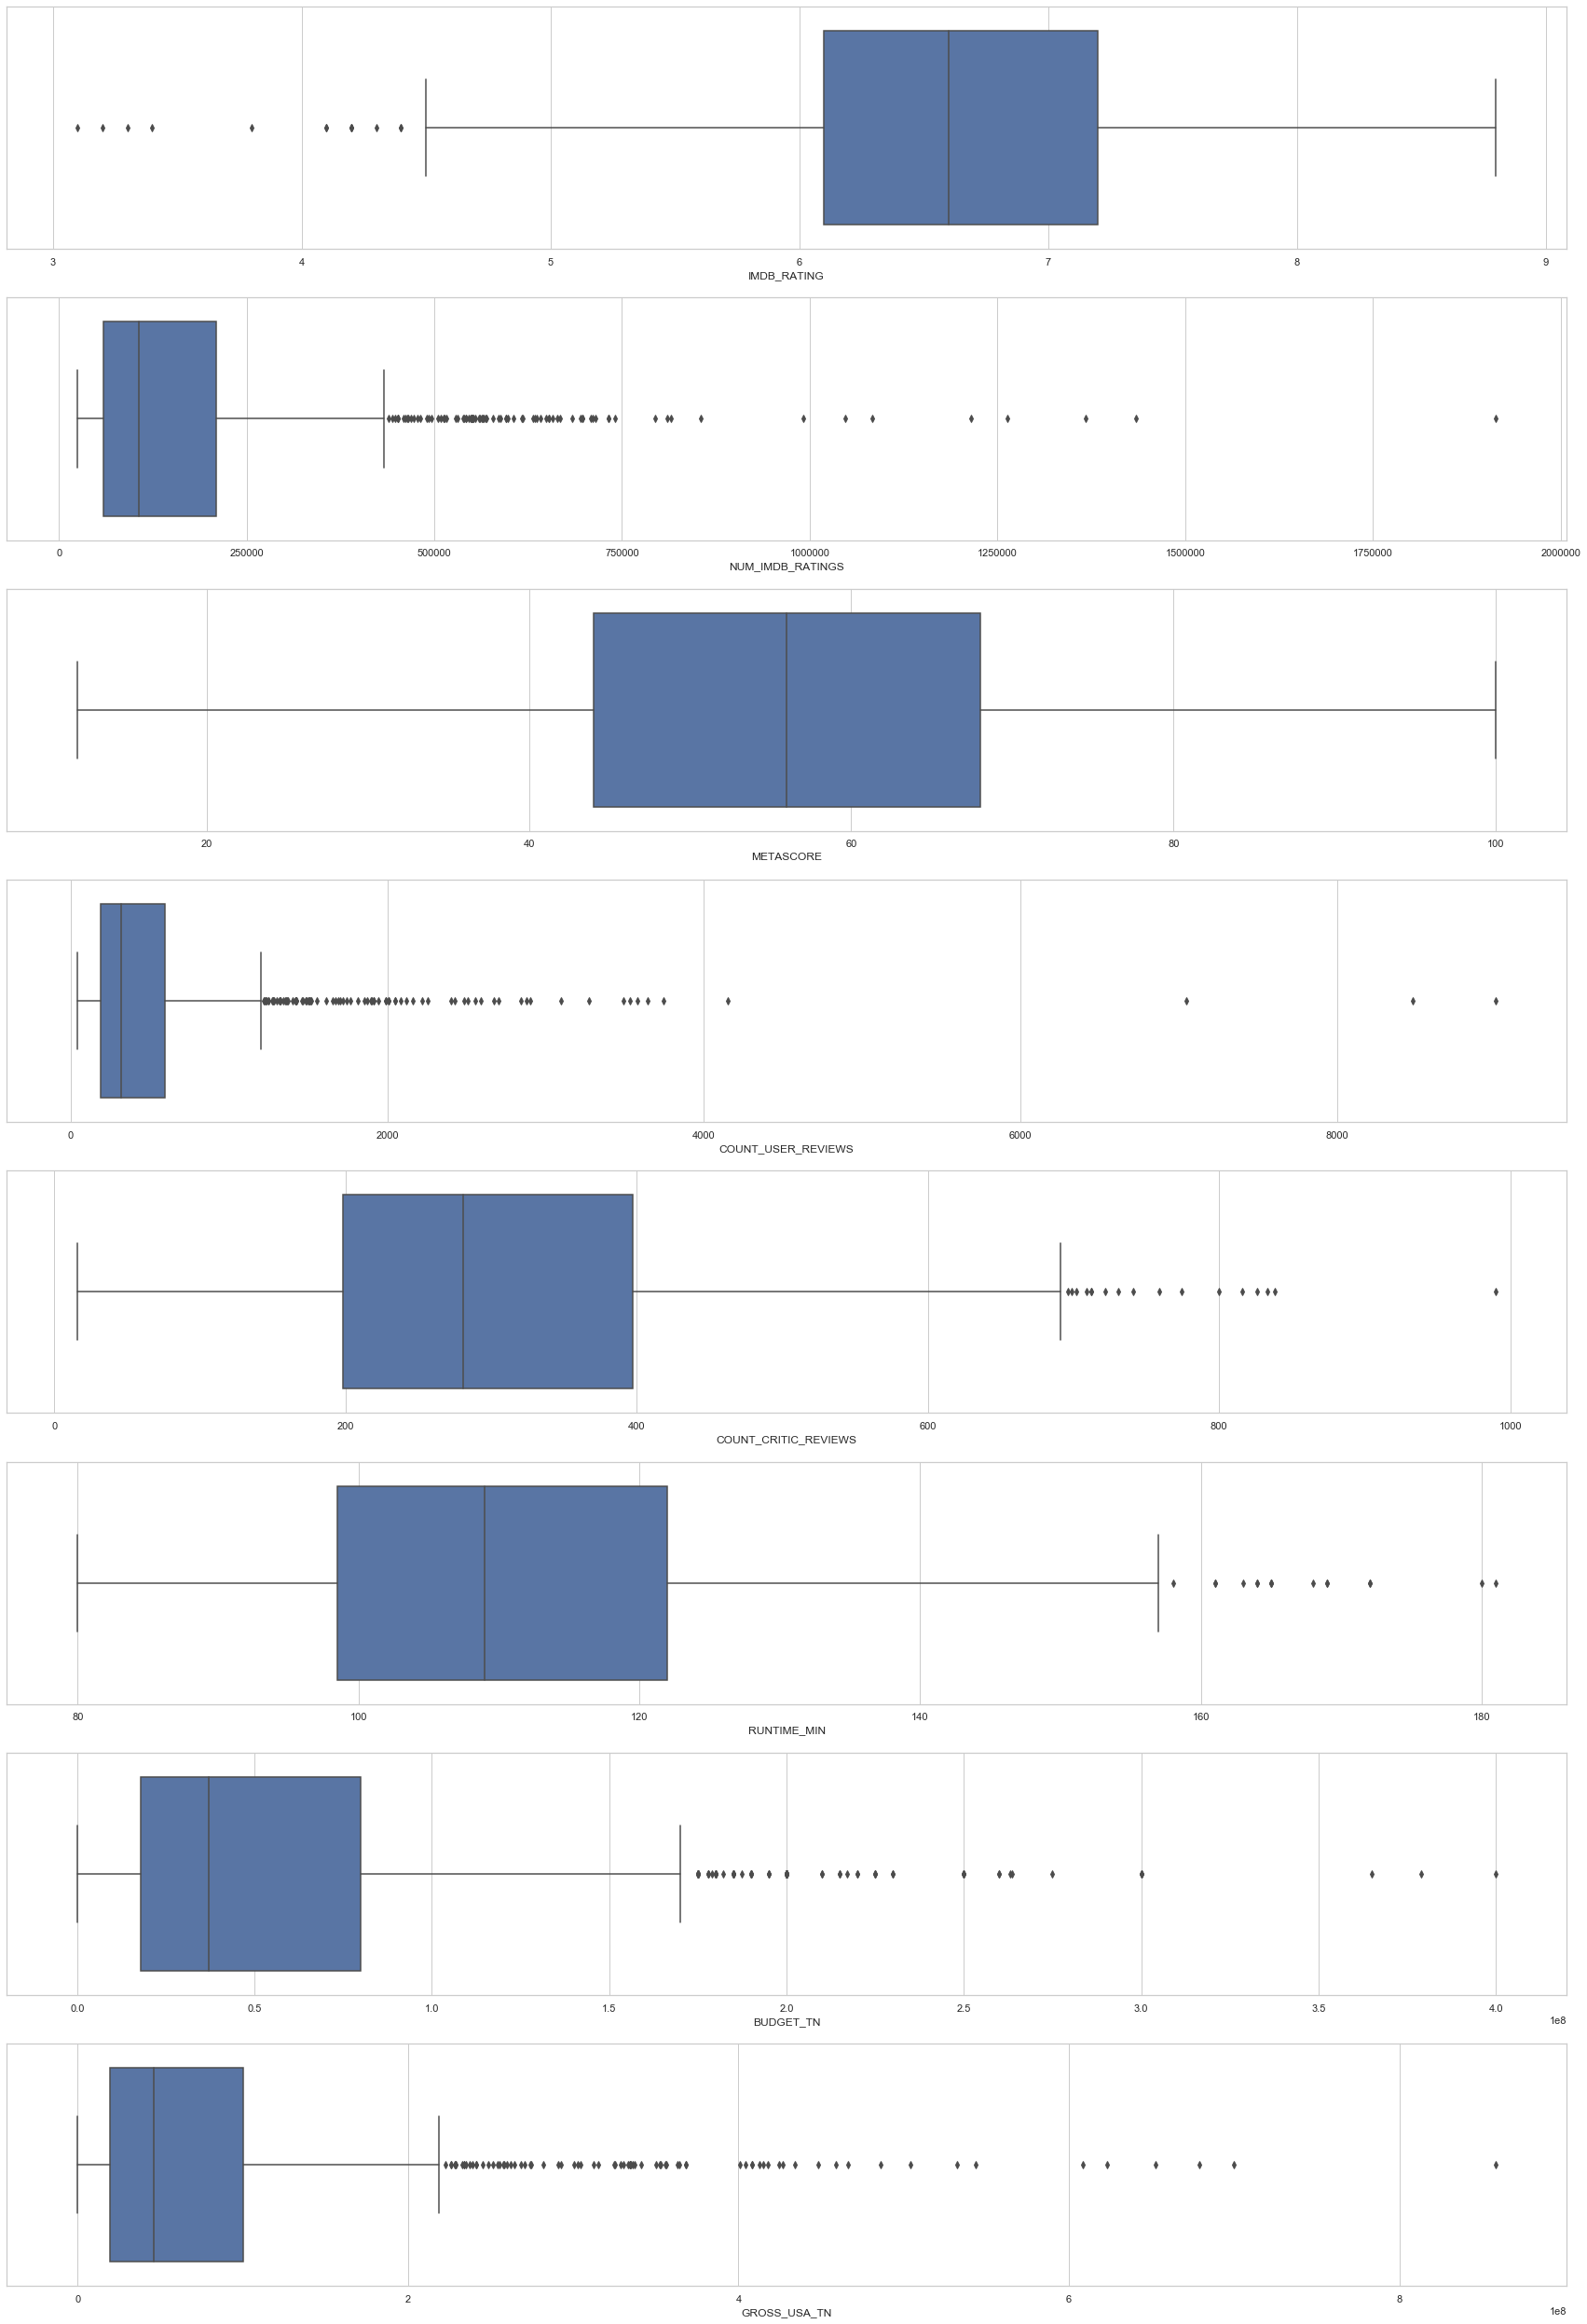

In [873]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(8, 1, figsize=(30, 45))
for col, i in zip(final_df[numeric_cols], range(1,len(numeric_cols))):
    plt.subplot(8,1,i)
    sns.boxplot(x=final_df[col])

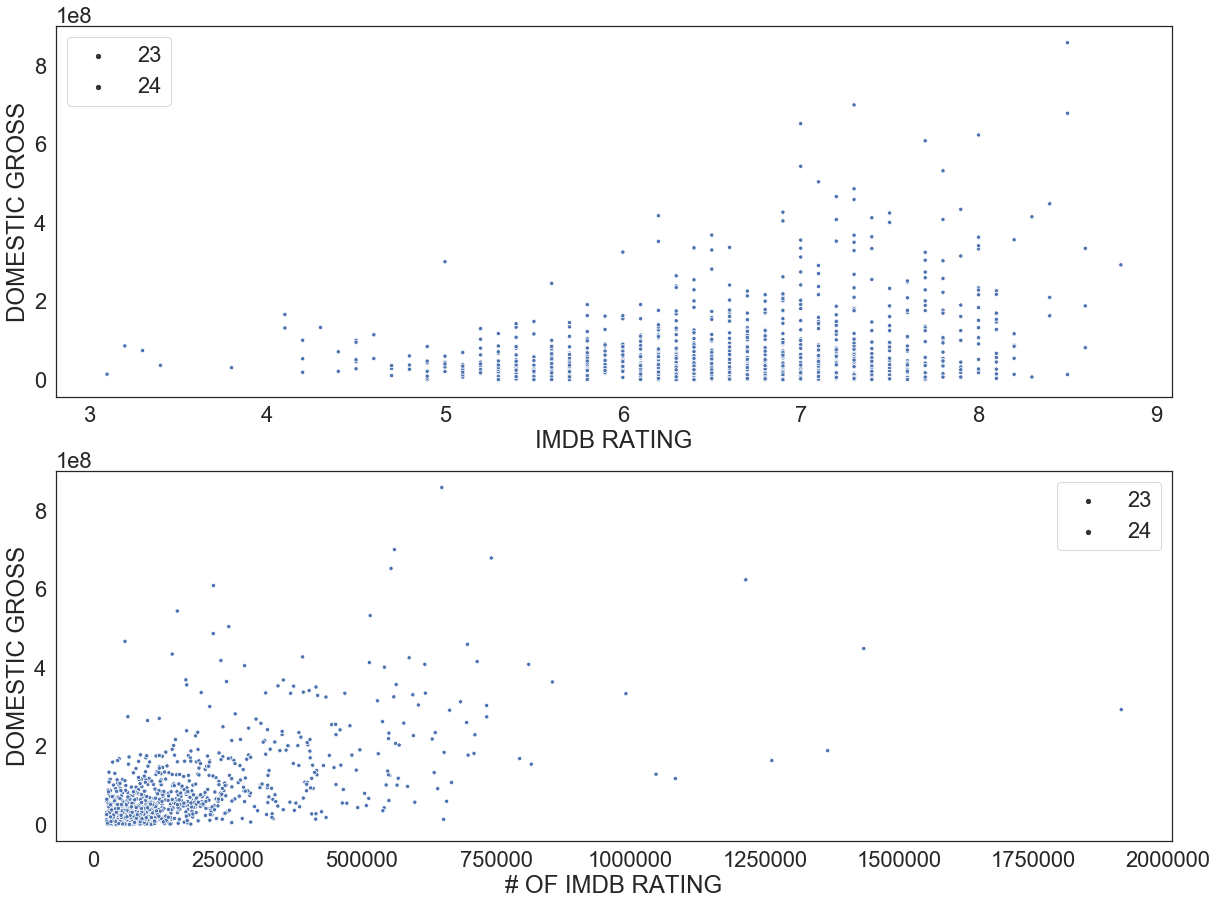

In [911]:
fig, axes = plt.subplots(2,1,figsize=(20,15))
ax1 = sns.scatterplot(final_df['IMDB_RATING'],final_df['GROSS_USA_TN'], size = 24, ax=axes[0])
ax1.set_xlabel('IMDB RATING')
ax1.set_ylabel('DOMESTIC GROSS')
ax2 = sns.scatterplot(final_df['NUM_IMDB_RATINGS'],final_df['GROSS_USA_TN'], size = 24, ax=axes[1])
ax2.set_xlabel('# OF IMDB RATING')
ax2.set_ylabel('DOMESTIC GROSS')
plt.savefig('imdb_charts.png');


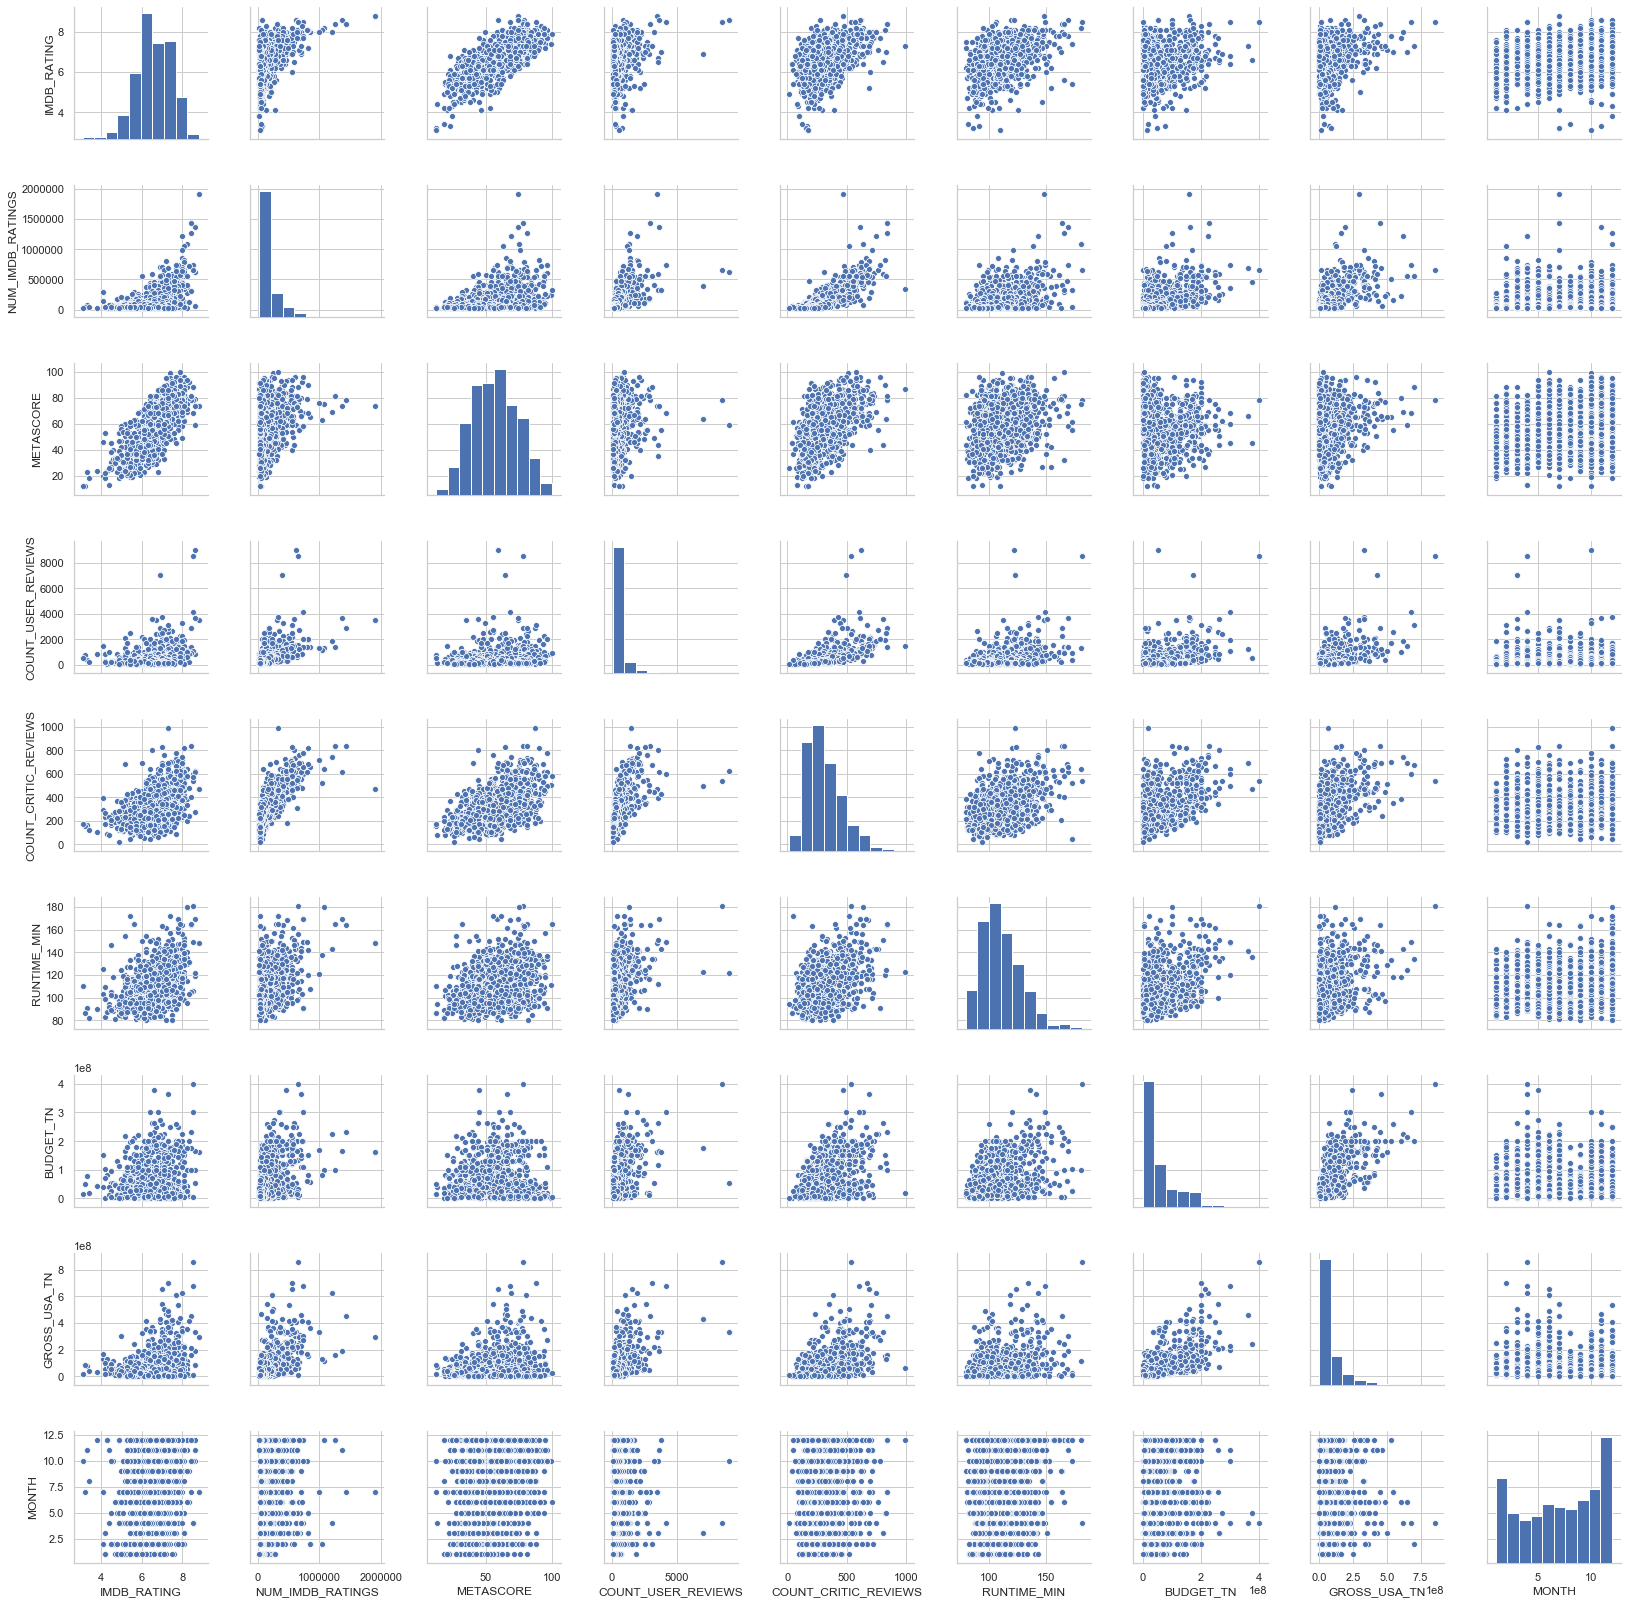

In [486]:
sns.pairplot(final_df[numeric_cols])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


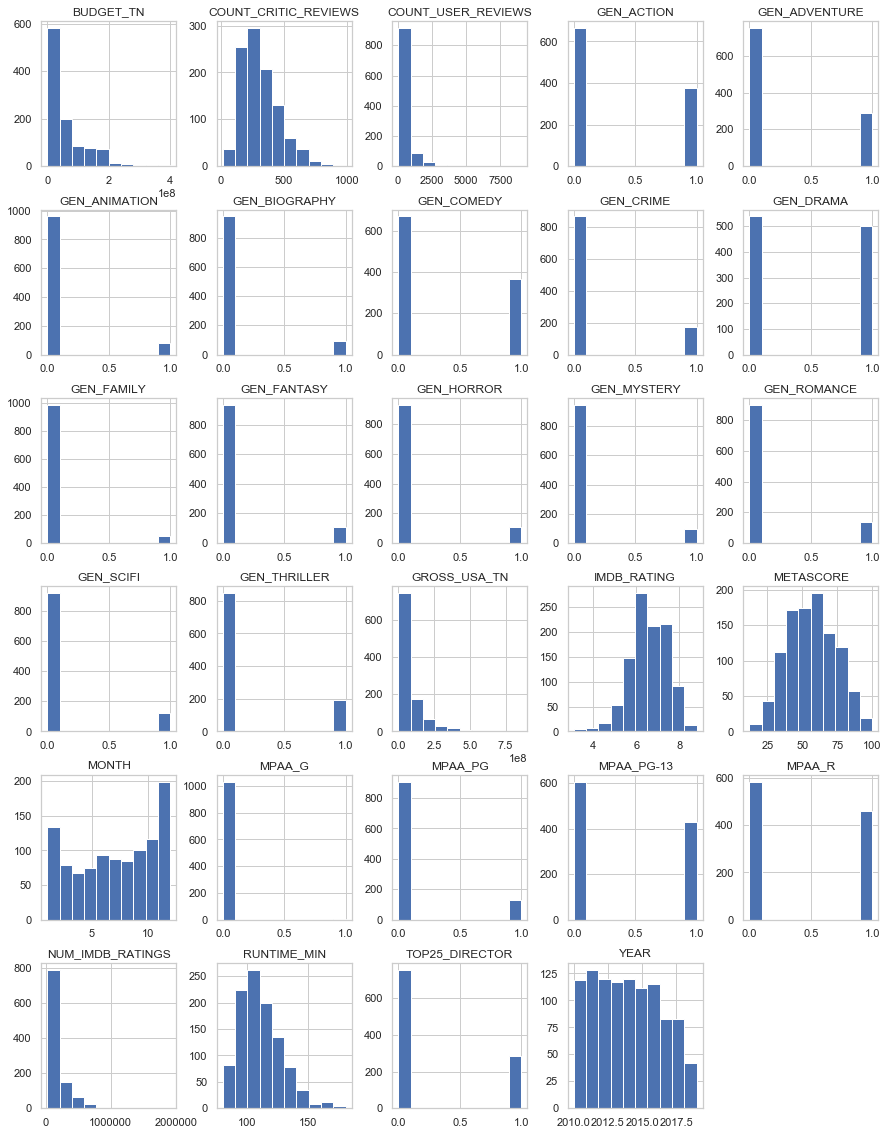

In [821]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
final_df.hist(ax = ax);

In [787]:
final_df.corr().GROSS_USA_TN.sort_values(ascending=False)

GROSS_USA_TN            1.000
BUDGET_TN               0.692
NUM_IMDB_RATINGS        0.594
COUNT_USER_REVIEWS      0.575
TOP25_DIRECTOR          0.532
COUNT_CRITIC_REVIEWS    0.478
GEN_ADVENTURE           0.465
RUNTIME_MIN             0.294
GEN_ANIMATION           0.289
IMDB_RATING             0.276
MPAA_PG                 0.236
GEN_SCIFI               0.212
GEN_ACTION              0.199
METASCORE               0.180
YEAR                    0.154
MPAA_PG-13              0.140
MPAA_G                  0.134
GEN_FAMILY              0.128
GEN_FANTASY             0.038
GEN_COMEDY             -0.001
MONTH                  -0.065
GEN_BIOGRAPHY          -0.091
GEN_MYSTERY            -0.095
GEN_THRILLER           -0.107
GEN_HORROR             -0.110
GEN_ROMANCE            -0.154
GEN_CRIME              -0.160
GEN_DRAMA              -0.297
MPAA_R                 -0.310
Name: GROSS_USA_TN, dtype: float64

# 3 fold CV

In [883]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=28)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.25, random_state=12)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    train_score = lr_model.score(X_train, y_train)
    test_score = lr_model.score(X_test, y_test)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('\nTrain R^2 score was:', train_score)
    print('\nTest R^2 score was:', test_score)
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}')

**Column Names**

In [277]:
final_df.columns

Index(['TITLE', 'YEAR', 'IMDB_RATING', 'NUM_IMDB_RATINGS', 'METASCORE',
       'COUNT_USER_REVIEWS', 'COUNT_CRITIC_REVIEWS', 'GROSS_USA',
       'RUNTIME_MIN', 'BUDGET_TN', 'GROSS_USA_TN', 'MONTH', 'GEN_ACTION',
       'GEN_ADVENTURE', 'GEN_ANIMATION', 'GEN_BIOGRAPHY', 'GEN_COMEDY',
       'GEN_CRIME', 'GEN_DRAMA', 'GEN_FAMILY', 'GEN_FANTASY', 'GEN_HORROR',
       'GEN_MYSTERY', 'GEN_ROMANCE', 'GEN_SCIFI', 'GEN_THRILLER', 'MPAA_G',
       'MPAA_PG', 'MPAA_PG-13', 'MPAA_R', 'TOP25_DIRECTOR'],
      dtype='object')

In [879]:
# Ignoring dummy variables

# Construct the data matrix
X = final_df[['IMDB_RATING', 'NUM_IMDB_RATINGS', 'COUNT_USER_REVIEWS',
              'METASCORE', 'COUNT_CRITIC_REVIEWS', 'RUNTIME_MIN', 'BUDGET_TN',
              'MONTH']]

# Choose the response variable
y = final_df['GROSS_USA_TN']

In [884]:
split_and_validate(X, y)


Train R^2 score was: 0.630727983670817

Test R^2 score was: 0.5920062308890424

Validation R^2 score was: 0.6566300391090145
Feature coefficient results: 

IMDB_RATING : -340002.49
NUM_IMDB_RATINGS : 146.83
COUNT_USER_REVIEWS : 35570.71
METASCORE : 879575.94
COUNT_CRITIC_REVIEWS : -81901.88
RUNTIME_MIN : -522946.64
BUDGET_TN : 0.93
MONTH : -1639088.33


In [928]:
# Using dummy variables

# Construct the data matrix
X2 = final_df[['IMDB_RATING', 'NUM_IMDB_RATINGS', 'METASCORE',
       'COUNT_USER_REVIEWS', 'COUNT_CRITIC_REVIEWS',
       'RUNTIME_MIN', 'BUDGET_TN', 'GEN_ACTION',
       'GEN_ADVENTURE', 'GEN_ANIMATION', 'GEN_BIOGRAPHY', 'GEN_COMEDY',
       'GEN_CRIME', 'GEN_DRAMA', 'GEN_FAMILY', 'GEN_FANTASY', 'GEN_HORROR',
       'GEN_MYSTERY', 'GEN_ROMANCE', 'GEN_SCIFI', 'GEN_THRILLER','MPAA_G',
        'MPAA_PG', 'MPAA_PG-13', 'MPAA_R', 'TOP25_DIRECTOR']]

# Choose the response variable
y = final_df['GROSS_USA_TN']

In [929]:
split_and_validate(X2, y)


Train R^2 score was: 0.6929107954448546

Test R^2 score was: 0.6544791118195272

Validation R^2 score was: 0.6961590887841455
Feature coefficient results: 

IMDB_RATING : -1672309.30
NUM_IMDB_RATINGS : 106.36
METASCORE : 448767.16
COUNT_USER_REVIEWS : 39687.63
COUNT_CRITIC_REVIEWS : -692.71
RUNTIME_MIN : -2478.56
BUDGET_TN : 0.60
GEN_ACTION : -7072295.16
GEN_ADVENTURE : -11664526.90
GEN_ANIMATION : 32357593.49
GEN_BIOGRAPHY : -1392598.33
GEN_COMEDY : 5404165.25
GEN_CRIME : -6623277.24
GEN_DRAMA : -23064291.83
GEN_FAMILY : 15322239.62
GEN_FANTASY : -22878306.38
GEN_HORROR : 4044279.03
GEN_MYSTERY : -5953575.85
GEN_ROMANCE : 832865.57
GEN_SCIFI : -8339062.59
GEN_THRILLER : -5869890.50
MPAA_G : 67514162.87
MPAA_PG : 32265405.90
MPAA_PG-13 : 19888655.61
MPAA_R : 5938550.04
TOP25_DIRECTOR : 39265432.27


In [964]:
log_y = np.log(y)

### PolynomialFeatures

### X1

In [636]:
# 60/20/20 train/test/val
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=28)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.25, random_state=12)

In [637]:
m = LinearRegression()
m.fit(X_train,y_train)
m.score(X_train,y_train)

0.6365929098973037

In [638]:
m.score(X_test,y_test)

0.5932379557916925

In [639]:
p = PolynomialFeatures(degree=2)
m.fit(p.fit_transform(X_train),y_train)
m.score(p.transform(X_train),y_train)

0.7146123617058215

In [640]:
m.score(p.transform(X_test),y_test)

0.6026325046292521

In [641]:
og_cols = X.columns
og_cols

Index(['IMDB_RATING', 'NUM_IMDB_RATINGS', 'COUNT_USER_REVIEWS',
       'COUNT_CRITIC_REVIEWS', 'RUNTIME_MIN', 'BUDGET_TN', 'METASCORE'],
      dtype='object')

In [642]:
p.get_feature_names(og_cols)

['1',
 'IMDB_RATING',
 'NUM_IMDB_RATINGS',
 'COUNT_USER_REVIEWS',
 'COUNT_CRITIC_REVIEWS',
 'RUNTIME_MIN',
 'BUDGET_TN',
 'METASCORE',
 'IMDB_RATING^2',
 'IMDB_RATING NUM_IMDB_RATINGS',
 'IMDB_RATING COUNT_USER_REVIEWS',
 'IMDB_RATING COUNT_CRITIC_REVIEWS',
 'IMDB_RATING RUNTIME_MIN',
 'IMDB_RATING BUDGET_TN',
 'IMDB_RATING METASCORE',
 'NUM_IMDB_RATINGS^2',
 'NUM_IMDB_RATINGS COUNT_USER_REVIEWS',
 'NUM_IMDB_RATINGS COUNT_CRITIC_REVIEWS',
 'NUM_IMDB_RATINGS RUNTIME_MIN',
 'NUM_IMDB_RATINGS BUDGET_TN',
 'NUM_IMDB_RATINGS METASCORE',
 'COUNT_USER_REVIEWS^2',
 'COUNT_USER_REVIEWS COUNT_CRITIC_REVIEWS',
 'COUNT_USER_REVIEWS RUNTIME_MIN',
 'COUNT_USER_REVIEWS BUDGET_TN',
 'COUNT_USER_REVIEWS METASCORE',
 'COUNT_CRITIC_REVIEWS^2',
 'COUNT_CRITIC_REVIEWS RUNTIME_MIN',
 'COUNT_CRITIC_REVIEWS BUDGET_TN',
 'COUNT_CRITIC_REVIEWS METASCORE',
 'RUNTIME_MIN^2',
 'RUNTIME_MIN BUDGET_TN',
 'RUNTIME_MIN METASCORE',
 'BUDGET_TN^2',
 'BUDGET_TN METASCORE',
 'METASCORE^2']

In [643]:
m.coef_

array([ 2.57259021e+01,  2.33613085e+04,  1.15521120e+03,  9.67470577e+04,
       -7.26482963e+05, -3.07850708e+04, -3.90551017e-01, -7.57597751e+03,
       -2.03907447e+03, -1.16256734e+02,  4.55190321e+03,  7.11665871e+04,
       -4.04058090e+05,  1.78614308e-01,  3.04064654e+05, -1.75157677e-04,
        1.61839106e-02, -7.74988399e-02,  1.61878575e+00,  2.11480601e-07,
       -2.84279885e+00, -4.43126834e+00,  4.09939477e+01, -1.21290941e+03,
        2.09413519e-04,  6.56392518e+02,  1.83698287e+02,  1.34685337e+03,
       -8.35166913e-04, -2.56682301e+03,  1.63190369e+04, -1.17486435e-02,
       -1.14559543e+04,  1.24782673e-09,  2.13256331e-02,  1.21081816e+03])

### X2 and log y

In [965]:
# 60/20/20 train/test/val
X_train, X_test, y_train, y_test = train_test_split(X2, log_y, test_size=.2, random_state=28)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.25, random_state=12)

In [966]:
m = LinearRegression()
m.fit(X_train,y_train)
m.score(X_train,y_train)

0.5185773714649643

In [967]:
m.score(X_test,y_test)

0.4804437569683251

In [968]:
p = PolynomialFeatures(degree=2)
m.fit(p.fit_transform(X_train),y_train)
m.score(p.transform(X_train),y_train)

0.5908725271208434

In [969]:
m.score(p.transform(X_test),y_test)

0.2974361680047807

In [970]:
og_cols = X2.columns
og_cols

Index(['IMDB_RATING', 'NUM_IMDB_RATINGS', 'METASCORE', 'COUNT_USER_REVIEWS',
       'COUNT_CRITIC_REVIEWS', 'RUNTIME_MIN', 'BUDGET_TN', 'GEN_ACTION',
       'GEN_ADVENTURE', 'GEN_ANIMATION', 'GEN_BIOGRAPHY', 'GEN_COMEDY',
       'GEN_CRIME', 'GEN_DRAMA', 'GEN_FAMILY', 'GEN_FANTASY', 'GEN_HORROR',
       'GEN_MYSTERY', 'GEN_ROMANCE', 'GEN_SCIFI', 'GEN_THRILLER', 'MPAA_G',
       'MPAA_PG', 'MPAA_PG-13', 'MPAA_R', 'TOP25_DIRECTOR'],
      dtype='object')

In [971]:
og_cols.shape

(26,)

In [972]:
p.get_feature_names(og_cols)

['1',
 'IMDB_RATING',
 'NUM_IMDB_RATINGS',
 'METASCORE',
 'COUNT_USER_REVIEWS',
 'COUNT_CRITIC_REVIEWS',
 'RUNTIME_MIN',
 'BUDGET_TN',
 'GEN_ACTION',
 'GEN_ADVENTURE',
 'GEN_ANIMATION',
 'GEN_BIOGRAPHY',
 'GEN_COMEDY',
 'GEN_CRIME',
 'GEN_DRAMA',
 'GEN_FAMILY',
 'GEN_FANTASY',
 'GEN_HORROR',
 'GEN_MYSTERY',
 'GEN_ROMANCE',
 'GEN_SCIFI',
 'GEN_THRILLER',
 'MPAA_G',
 'MPAA_PG',
 'MPAA_PG-13',
 'MPAA_R',
 'TOP25_DIRECTOR',
 'IMDB_RATING^2',
 'IMDB_RATING NUM_IMDB_RATINGS',
 'IMDB_RATING METASCORE',
 'IMDB_RATING COUNT_USER_REVIEWS',
 'IMDB_RATING COUNT_CRITIC_REVIEWS',
 'IMDB_RATING RUNTIME_MIN',
 'IMDB_RATING BUDGET_TN',
 'IMDB_RATING GEN_ACTION',
 'IMDB_RATING GEN_ADVENTURE',
 'IMDB_RATING GEN_ANIMATION',
 'IMDB_RATING GEN_BIOGRAPHY',
 'IMDB_RATING GEN_COMEDY',
 'IMDB_RATING GEN_CRIME',
 'IMDB_RATING GEN_DRAMA',
 'IMDB_RATING GEN_FAMILY',
 'IMDB_RATING GEN_FANTASY',
 'IMDB_RATING GEN_HORROR',
 'IMDB_RATING GEN_MYSTERY',
 'IMDB_RATING GEN_ROMANCE',
 'IMDB_RATING GEN_SCIFI',
 'IMDB_RATING

In [973]:
m.coef_

array([-3.48204988e-03, -9.04637048e-04, -5.41791978e-05, -2.12580959e-03,
       -2.68810914e-04, -5.58243412e-03, -1.00544067e-03, -4.03137573e-08,
       -1.40831424e-05, -1.16581732e-04,  9.71732259e-05, -3.48998755e-05,
        9.49415376e-05, -5.75620441e-05, -6.01683563e-05,  1.89975026e-05,
        4.25113666e-06, -1.65019480e-04,  4.31002233e-05,  3.93907542e-05,
        1.89931343e-06, -5.24045693e-05, -1.84993329e-05,  7.64008790e-05,
        6.51452150e-05, -1.22062961e-04,  5.92570572e-05, -3.02248632e-04,
       -2.67195768e-06, -1.53529744e-02,  9.11032938e-05,  3.63140061e-03,
       -3.24622110e-03,  1.80061033e-09, -3.46134821e-04, -7.49829817e-04,
        6.19453626e-04, -2.30769126e-04,  3.90405158e-04, -5.03308730e-05,
       -2.81092879e-04,  7.04650388e-05, -1.55977912e-04, -9.07100304e-04,
        4.60230132e-04,  1.23076265e-04, -1.54908825e-04,  8.54972793e-05,
       -1.28094198e-04,  4.73151651e-04,  5.70629638e-04, -8.91898268e-04,
        5.27002866e-04, -

### X2

In [930]:
# 60/20/20 train/test/val
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=.2, random_state=28)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.25, random_state=12)

In [931]:
m = LinearRegression()
m.fit(X_train,y_train)
m.score(X_train,y_train)

0.6929107954448546

In [932]:
m.score(X_test,y_test)

0.6544791118195272

In [933]:
p = PolynomialFeatures(degree=2)
m.fit(p.fit_transform(X_train),y_train)
m.score(p.transform(X_train),y_train)

0.6856824907401546

In [934]:
m.score(p.transform(X_test),y_test)

0.44337398962498564

In [935]:
og_cols = X2.columns
og_cols

Index(['IMDB_RATING', 'NUM_IMDB_RATINGS', 'METASCORE', 'COUNT_USER_REVIEWS',
       'COUNT_CRITIC_REVIEWS', 'RUNTIME_MIN', 'BUDGET_TN', 'GEN_ACTION',
       'GEN_ADVENTURE', 'GEN_ANIMATION', 'GEN_BIOGRAPHY', 'GEN_COMEDY',
       'GEN_CRIME', 'GEN_DRAMA', 'GEN_FAMILY', 'GEN_FANTASY', 'GEN_HORROR',
       'GEN_MYSTERY', 'GEN_ROMANCE', 'GEN_SCIFI', 'GEN_THRILLER', 'MPAA_G',
       'MPAA_PG', 'MPAA_PG-13', 'MPAA_R', 'TOP25_DIRECTOR'],
      dtype='object')

In [952]:
og_cols.shape

(26,)

In [954]:
p.get_feature_names(og_cols)

['1',
 'IMDB_RATING',
 'NUM_IMDB_RATINGS',
 'METASCORE',
 'COUNT_USER_REVIEWS',
 'COUNT_CRITIC_REVIEWS',
 'RUNTIME_MIN',
 'BUDGET_TN',
 'GEN_ACTION',
 'GEN_ADVENTURE',
 'GEN_ANIMATION',
 'GEN_BIOGRAPHY',
 'GEN_COMEDY',
 'GEN_CRIME',
 'GEN_DRAMA',
 'GEN_FAMILY',
 'GEN_FANTASY',
 'GEN_HORROR',
 'GEN_MYSTERY',
 'GEN_ROMANCE',
 'GEN_SCIFI',
 'GEN_THRILLER',
 'MPAA_G',
 'MPAA_PG',
 'MPAA_PG-13',
 'MPAA_R',
 'TOP25_DIRECTOR',
 'IMDB_RATING^2',
 'IMDB_RATING NUM_IMDB_RATINGS',
 'IMDB_RATING METASCORE',
 'IMDB_RATING COUNT_USER_REVIEWS',
 'IMDB_RATING COUNT_CRITIC_REVIEWS',
 'IMDB_RATING RUNTIME_MIN',
 'IMDB_RATING BUDGET_TN',
 'IMDB_RATING GEN_ACTION',
 'IMDB_RATING GEN_ADVENTURE',
 'IMDB_RATING GEN_ANIMATION',
 'IMDB_RATING GEN_BIOGRAPHY',
 'IMDB_RATING GEN_COMEDY',
 'IMDB_RATING GEN_CRIME',
 'IMDB_RATING GEN_DRAMA',
 'IMDB_RATING GEN_FAMILY',
 'IMDB_RATING GEN_FANTASY',
 'IMDB_RATING GEN_HORROR',
 'IMDB_RATING GEN_MYSTERY',
 'IMDB_RATING GEN_ROMANCE',
 'IMDB_RATING GEN_SCIFI',
 'IMDB_RATING

In [937]:
m.coef_

array([-2.16608380e+05,  1.75180205e+04,  1.53963610e+03, -2.59201481e+04,
       -1.67053759e+05, -2.62684499e+05, -6.37939386e+04, -2.66613813e+00,
        3.81406948e+02, -3.55129996e+03,  5.81017470e+03, -1.37932939e+03,
        5.27514609e+02, -4.39182923e+02, -8.17327665e+02, -4.32444649e+02,
        3.44169179e+03, -1.77965851e+03,  3.47369503e+03, -1.23796497e+03,
        8.89674850e+02,  2.24801717e+03,  1.97184351e+02,  1.81529206e+02,
        3.30695563e+02, -7.64421334e+01,  4.84992242e+02, -3.13086529e+04,
       -1.14709580e+02, -3.18357171e+05, -5.21780356e+03,  1.70234298e+05,
       -3.55020699e+05,  1.88110444e-01,  1.92631446e+04, -1.35072198e+04,
        3.86328555e+04, -1.65229994e+04,  1.22164097e+04,  3.21124945e+03,
        1.46152271e+03, -3.62447171e+03, -4.06176222e+03, -1.16100899e+04,
        7.29391512e+03, -7.92278995e+02, -7.93562507e+03,  2.44212436e+04,
       -1.45665873e+03,  8.89193098e+03,  8.25641852e+03, -1.32710569e+04,
        2.24944334e+04, -

## 5. Automated Regularization Strength Tuning via Cross-validation 

### Using LassoCV to find the best alpha via Cross-Validation

# Scaling

## Polynomial

In [938]:
## Scale the data as before
std = StandardScaler()
std.fit(p.transform(X_train))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [939]:
## Scale the Predictors on both the train and test set
X_tr = std.transform(p.transform(X_train))
X_te = std.transform(p.transform(X_test))
X_va = std.transform(p.transform(X_val))

# Lasso

In [940]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(6,10,300)

lasso_model = LassoCV(alphas = alphavec, cv=5, tol=0.00001)
lasso_model.fit(X_tr, y_train)

LassoCV(alphas=array([1.00000000e+06, 1.03128316e+06, 1.06354496e+06, 1.09681601e+06,
       1.13112788e+06, 1.16651313e+06, 1.20300535e+06, 1.24063916e+06,
       1.27945027e+06, 1.31947552e+06, 1.36075289e+06, 1.40332154e+06,
       1.44722187e+06, 1.49249555e+06, 1.53918552e+06, 1.58733611e+06,
       1.63699300e+06, 1.68820332e+06, 1.74101565e+06, 1.79548012e+06,
       1.85164842e+06, 1.90957383e+0...
       7.12595063e+09, 7.34887289e+09, 7.57876886e+09, 7.81585671e+09,
       8.06036141e+09, 8.31251499e+09, 8.57255673e+09, 8.84073340e+09,
       9.11729948e+09, 9.40251743e+09, 9.69665789e+09, 1.00000000e+10]),
        copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=None, selection='cyclic', tol=1e-05,
        verbose=False)

In [941]:
# This is the best alpha value it found
lasso_model.alpha_

3760545.399658168

In [942]:
lasso_model.coef_.shape

(378,)

In [943]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
coef_df = pd.DataFrame(list(zip(p.get_feature_names(og_cols), lasso_model.coef_)),columns = ['VARIABLE','COEF'])
coef_df

,VARIABLE,COEF
0,1,0.000
1,IMDB_RATING,0.000
2,NUM_IMDB_RATINGS,10477329.417
3,METASCORE,0.000
4,COUNT_USER_REVIEWS,0.000
...,...,...
373,MPAA_PG-13 MPAA_R,0.000
374,MPAA_PG-13 TOP25_DIRECTOR,0.000
375,MPAA_R^2,-0.000
376,MPAA_R TOP25_DIRECTOR,-0.000


In [951]:
mask = coef_df['COEF'] != 0
coef_df[mask]

,VARIABLE,COEF
2,NUM_IMDB_RATINGS,10477329.417
51,IMDB_RATING MPAA_R,-926081.181
63,NUM_IMDB_RATINGS GEN_COMEDY,3087668.879
66,NUM_IMDB_RATINGS GEN_FAMILY,1359285.939
79,METASCORE COUNT_USER_REVIEWS,10226552.958
82,METASCORE BUDGET_TN,22604658.381
89,METASCORE GEN_DRAMA,-1804349.548
90,METASCORE GEN_FAMILY,294078.131
105,COUNT_USER_REVIEWS BUDGET_TN,5758712.746
108,COUNT_USER_REVIEWS GEN_ANIMATION,13235828.381


In [945]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te)
val_set_pred = lasso_model.predict(X_va)

In [946]:
# Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

In [947]:
# Find the MAE and R^2 on the test set using this model
mae(y_test, test_set_pred)

38276736.4012258

In [948]:
r2_score(y_test, test_set_pred)

0.7012495182768077

In [949]:
r2_score(y_val, val_set_pred)

0.726764962007511

## Linear Scaling and Regularization

In [703]:
## Scale the data as before
std = StandardScaler()
std.fit(X_train.values)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [704]:
## Scale the Predictors on both the train and test set
X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)
X_va = std.transform(X_val.values)

# Lasso

In [705]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(5,10,200)

lasso_model = LassoCV(alphas = alphavec, cv=5, tol=0.00001)
lasso_model.fit(X_tr, y_train)

LassoCV(alphas=array([1.00000000e+05, 1.05956018e+05, 1.12266777e+05, 1.18953407e+05,
       1.26038293e+05, 1.33545156e+05, 1.41499130e+05, 1.49926843e+05,
       1.58856513e+05, 1.68318035e+05, 1.78343088e+05, 1.88965234e+05,
       2.00220037e+05, 2.12145178e+05, 2.24780583e+05, 2.38168555e+05,
       2.52353917e+05, 2.67384162e+05, 2.83309610e+05, 3.00183581e+05,
       3.18062569e+05, 3.37006433e+0...
       5.29197874e+09, 5.60716994e+09, 5.94113398e+09, 6.29498899e+09,
       6.66991966e+09, 7.06718127e+09, 7.48810386e+09, 7.93409667e+09,
       8.40665289e+09, 8.90735464e+09, 9.43787828e+09, 1.00000000e+10]),
        copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=None, selection='cyclic', tol=1e-05,
        verbose=False)

In [706]:
# This is the best alpha value it found
lasso_model.alpha_

1431458.9375234786

In [707]:
lasso_model.coef_.shape

(26,)

In [708]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
coef_df = pd.DataFrame(list(zip(p.get_feature_names(og_cols), lasso_model.coef_)),columns = ['VARIABLE','COEF'])
coef_df

,VARIABLE,COEF
0,1,0.000
1,IMDB_RATING,19508493.653
2,NUM_IMDB_RATINGS,5766029.989
3,METASCORE,26748742.588
4,COUNT_USER_REVIEWS,0.000
5,COUNT_CRITIC_REVIEWS,-0.000
6,RUNTIME_MIN,35281738.354
7,BUDGET_TN,-3246183.181
8,GEN_ACTION,-2074539.780
9,GEN_ADVENTURE,6479558.614


In [709]:
mask = coef_df['COEF'] != 0
coef_df[mask]

,VARIABLE,COEF
1,IMDB_RATING,19508493.653
2,NUM_IMDB_RATINGS,5766029.989
3,METASCORE,26748742.588
6,RUNTIME_MIN,35281738.354
7,BUDGET_TN,-3246183.181
8,GEN_ACTION,-2074539.780
9,GEN_ADVENTURE,6479558.614
11,GEN_BIOGRAPHY,4688639.957
12,GEN_COMEDY,-2097059.526
13,GEN_CRIME,-7936423.098


In [710]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te)
val_set_pred = lasso_model.predict(X_va)

In [711]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

In [712]:
## Find the MAE and R^2 on the test set using this model
mae(y_test, test_set_pred)

37876463.472147696

In [713]:
r2_score(y_test, test_set_pred)

0.6613176436680395

In [714]:
r2_score(y_val, val_set_pred)

0.6612716925888416

# Ridge

In [562]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(14,20,200)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_train, y_train)

RidgeCV(alphas=array([1.00000000e+14, 1.07189132e+14, 1.14895100e+14, 1.23155060e+14,
       1.32008840e+14, 1.41499130e+14, 1.51671689e+14, 1.62575567e+14,
       1.74263339e+14, 1.86791360e+14, 2.00220037e+14, 2.14614120e+14,
       2.30043012e+14, 2.46581108e+14, 2.64308149e+14, 2.83309610e+14,
       3.03677112e+14, 3.25508860e+14, 3.48910121e+14, 3.73993730e+14,
       4.00880633e+14, 4.29700470e+1...
       2.67384162e+19, 2.86606762e+19, 3.07211300e+19, 3.29297126e+19,
       3.52970730e+19, 3.78346262e+19, 4.05546074e+19, 4.34701316e+19,
       4.65952567e+19, 4.99450512e+19, 5.35356668e+19, 5.73844165e+19,
       6.15098579e+19, 6.59318827e+19, 7.06718127e+19, 7.57525026e+19,
       8.11984499e+19, 8.70359136e+19, 9.32930403e+19, 1.00000000e+20]),
        cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
        store_cv_values=False)

In [563]:
ridge_model.alpha_

100000000000000.0

In [565]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
list(zip(X_train.columns, ridge_model.coef_))

[('IMDB_RATING', 0.00010975310344069425),
 ('NUM_IMDB_RATINGS', 28.489476474492413),
 ('METASCORE', 0.002137466722409368),
 ('COUNT_USER_REVIEWS', 0.0953668870917333),
 ('COUNT_CRITIC_REVIEWS', 0.015459860037002254),
 ('RUNTIME_MIN', 0.0003815195029755643),
 ('BUDGET_TN', 1.0623185185499493),
 ('GEN_ACTION', -2.3650360458535506e-05),
 ('GEN_ADVENTURE', 5.127785227580621e-06),
 ('GEN_ANIMATION', 2.150061553996017e-05),
 ('GEN_BIOGRAPHY', 4.009115554625746e-06),
 ('GEN_COMEDY', 2.6685223519077795e-05),
 ('GEN_CRIME', -1.1562598764480941e-05),
 ('GEN_DRAMA', -7.0283629297300365e-06),
 ('GEN_FAMILY', -2.2799040265909935e-06),
 ('GEN_FANTASY', -2.2165058531395848e-05),
 ('GEN_HORROR', 3.7511574457779035e-06),
 ('GEN_MYSTERY', 1.0153248075365678e-06),
 ('GEN_ROMANCE', -2.5632770508334614e-06),
 ('GEN_SCIFI', -2.5473633488786315e-06),
 ('GEN_THRILLER', -1.633552118058429e-06),
 ('MPAA_G', 2.5480081814947277e-06),
 ('MPAA_PG', 1.6930178287482053e-05),
 ('MPAA_PG-13', -1.199813589768146e-05),
 

In [566]:
# Make predictions on the test set using the new model
test_set_pred = ridge_model.predict(X_test)

In [567]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

In [568]:
# Find the MAE and R^2 on the test set using this model
mae(y_test, test_set_pred)

36069986.37261103

In [569]:
r2_score(y_test, test_set_pred)

0.5275801630424222

### Residuals

In [833]:
y1 = final_df.GROSS_USA_TN

In [834]:
lr = LinearRegression()
fit = lr.fit(X,y1)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


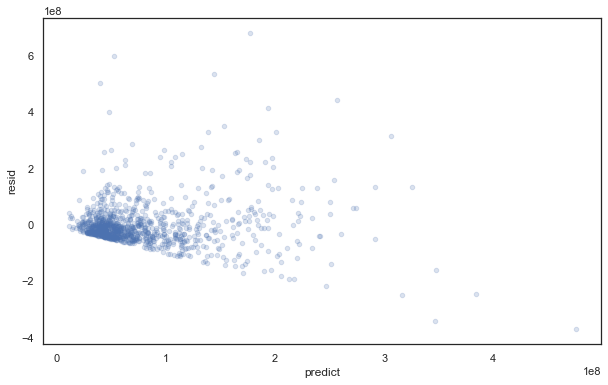

In [836]:
# Plot your predicted values on the x-axis, and your residuals on the y-axis

final_df['predict']=fit.predict(X)
final_df['resid']=final_df.GROSS_USA_TN-final_df.predict
with sns.axes_style('white'):
    plot=final_df.plot(kind='scatter',
                  x='predict',y='resid',alpha=0.2,figsize=(10,6))

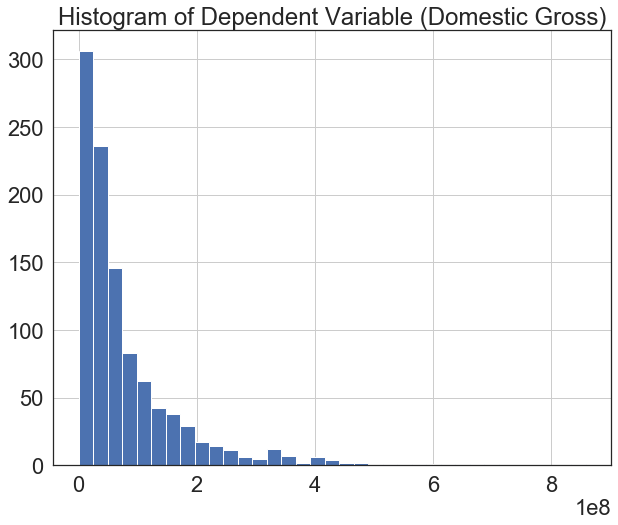

In [959]:
# inspect histogram
plt.figure(figsize = (10,8))
final_df.GROSS_USA_TN.hist(bins=35)
plt.title('Histogram of Dependent Variable (Domestic Gross)')
plt.savefig('domestic_gross_hist.png');

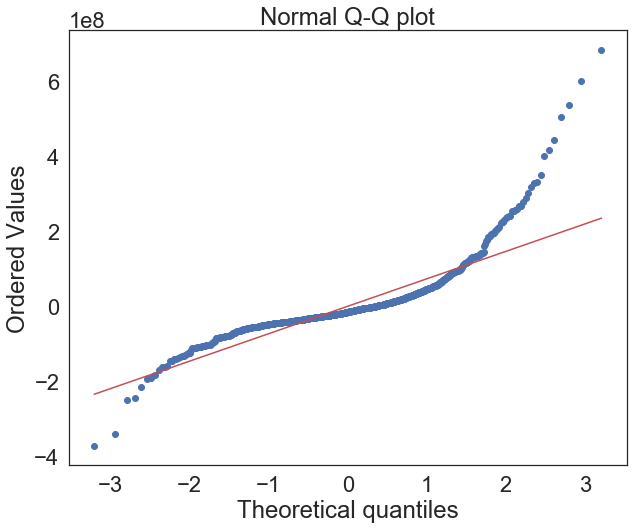

In [961]:
# diagnose/inspect residual normality using qqplot:
plt.figure(figsize = (10,8))
stats.probplot(final_df['resid'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
# plt.show()
plt.savefig('qqplot.png');

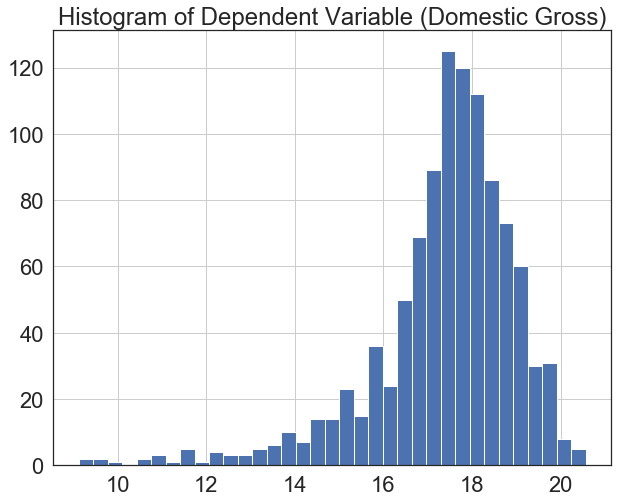

In [963]:
plt.figure(figsize = (10,8))
np.log(y).hist(bins=35)
plt.title('Histogram of Dependent Variable (Domestic Gross)')
plt.savefig('domestic_gross_hist.png');